Mixed-Curvature t-SNE: Complete Technical Specification

I. Core Framework:

A. Foundation Layer

1.	Basic t-SNE implementation
- Euclidean baseline
- Initialization strategies for different spaces
- Perplexity computation methods

2.	Probability computation framework
- Input space distributions
  - Gaussian kernel (baseline)
  - Wrapped normal for non-Euclidean spaces

- Output space distributions
  - Student t-distribution
  - Cauchy distribution
  - Gaussian distribution

3.	Optimization infrastructure
- Space-specific gradient computations
- Numerical stability safeguards

B. Geometric Spaces

1.	Space Implementations
- Euclidean utilities
- Hyperbolic utilities (Poincaré ball model)
- Spherical utilities

2.	Product Space Framework
- Space composition mechanisms
- Curvature parameter handling
- Transition regions between spaces

3.	Distance Metrics
- Component-specific metrics
- Hybrid distance computations
- Adaptive weighting mechanisms

II. Advanced Components

A. Distribution Framework

1.	Input Space Distributions
- Implementation of all variants
- Combination strategies for product spaces
- Numerical stability considerations

2.	Output Space Distributions
- Space-specific distribution implementations
- Hybrid distribution handling
- Parameter optimization

B. Divergence Measures

1.	Basic Divergences
- KL-divergence implementation
- F-divergence variants

2.	Advanced Features
- Numerical stability improvements
- Adaptive divergence selection
- Mixed-space considerations

C. Acceleration Structures

1.	Tree-based Acceleration
- Polar Quadtree implementation
- Barnes-Hut adaptation
- Hybrid acceleration strategies

2.	Optimization Techniques
- Space-specific optimizations
- Memory efficiency improvements
- Parallel computation strategies

III. Evaluation Framework

A. Quality Assessment

1.	Structure Preservation
- Local structure metrics
- Global structure metrics
- Hierarchy preservation

2.	Mixed-Curvature Specific
- Space composition effectiveness
- Transition quality metrics
- Curvature utilization analysis

B. Performance Metrics

1.	Computational Efficiency
- Runtime analysis
- Memory usage
- Convergence rates

2.	Comparative Analysis
- Single-space baselines
- State-of-the-art comparisons
- Ablation studies

C. Visualization Tools

1.	Basic Visualization
- Component-specific views
- Interactive visualization tools
- Progress monitoring

2.	Advanced Features
- Transition region visualization
- Component contribution analysis
- Quality assessment tools

IV. Implementation and Testing

A. Dataset Integration

1.	Hierarchical Data
- WordNet mammal subtree
- Gene expression data

2.	Network Data
- Social networks
- Citation networks

3.	Benchmark Data
- MNIST
- Single-cell RNA sequences

B. Testing Framework

1.	Unit Testing
- Component-level tests
- Integration tests
- Performance tests

2.	Validation
- Correctness verification
- Stability analysis
- Edge case handling

C. Optimization and Refinement

1.	Parameter Tuning
- Space composition parameters
- Distribution parameters
- Optimization parameters

2.	Performance Optimization
- Computational efficiency
- Memory optimization
- Numerical stability

V. Theoretical Analysis

1.	Convergence Analysis
- Convergence guarantees
- Stability conditions

2.	Complexity Analysis
- Computational complexity
- Space complexity

3.	Error Analysis
- Error bounds
- Approximation quality

In [ ]:
# Environment Setup
!pip install torch numpy matplotlib scikit-learn geomstats

import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from scipy.stats import wishart
from scipy.stats import vonmises
from sklearn.manifold import TSNE
from scipy.special import logsumexp
from sklearn.manifold import _utils
from sklearn.datasets import fetch_openml
from sklearn.utils import check_random_state
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from torch.distributions import Normal, StudentT
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.hyperboloid import Hyperboloid
from geomstats.geometry.hypersphere import Hypersphere

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 42.5 MB/s eta 0:00:00


Loaded MNIST data with shape: (1000, 784)
Number of classes: 10


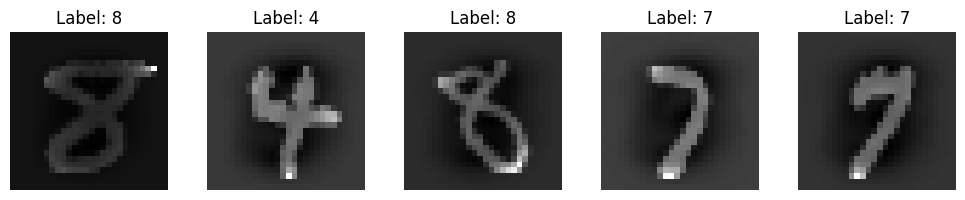

In [ ]:
# Data Loading and Preprocessing
def load_mnist(n_samples=1000, random_state=42):
    """
    Load and preprocess MNIST dataset

    Parameters:
    -----------
    n_samples : int
        Number of samples to load
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    X : array of shape (n_samples, n_features)
        The input data
    y : array of shape (n_samples,)
        The labels
    """
    # Load MNIST
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

    # Convert to float32 for faster processing
    X = X.astype('float32')

    # Normalize the data
    X = StandardScaler().fit_transform(X)

    # Subsample if needed
    if n_samples < X.shape[0]:
        np.random.seed(random_state)
        idx = np.random.choice(X.shape[0], n_samples, replace=False)
        X = X[idx]
        y = y[idx]

    return X, y

# Load a subset of MNIST for initial testing
X_mnist, y_mnist = load_mnist(n_samples=1000)

print(f"Loaded MNIST data with shape: {X_mnist.shape}")
print(f"Number of classes: {len(np.unique(y_mnist))}")

# Visualize a few digits to verify the data
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_mnist[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {y_mnist[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


Running baseline t-SNE visualization...
Starting t-SNE fitting...
Input data shape: (1000, 784)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.084s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 7.489475
[t-SNE] KL divergence after 100 iterations with early exaggeration: 68.106995
[t-SNE] KL divergence after 1000 iterations: 1.045781
t-SNE fitting complete!
Output embedding shape: (1000, 2)


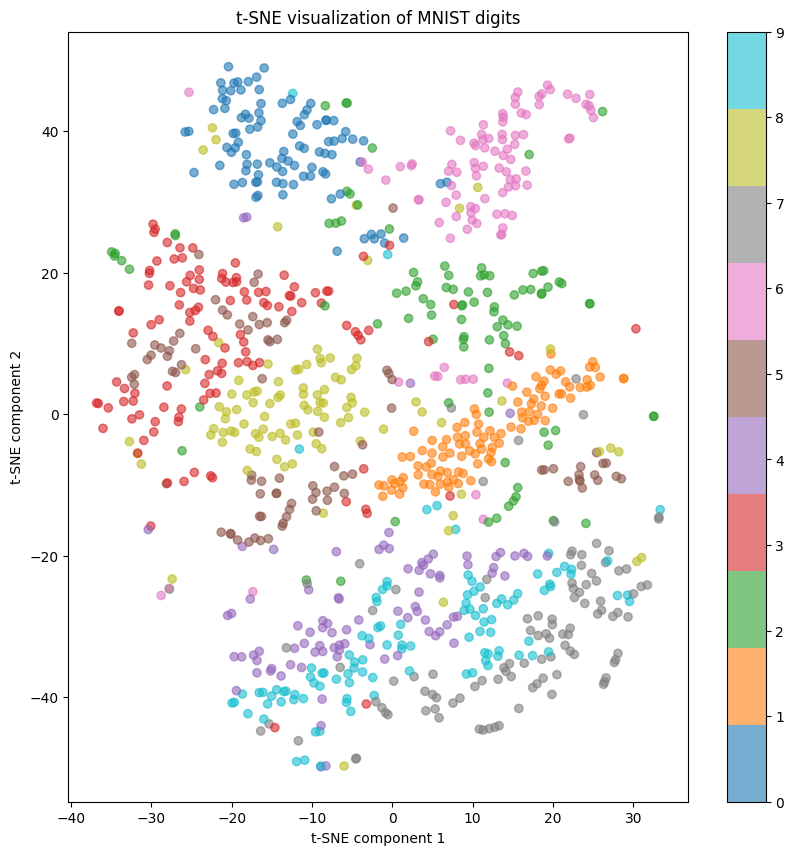


t-SNE embedding shape: (1000, 2)
Final KL divergence: 1.0457814931869507


In [ ]:
# Baseline t-SNE Implementation
def compute_perplexity(distances, sigmas, target_perplexity):
    """
    Compute perplexity and its gradient for the given distances and sigmas
    """
    prob = np.exp(-distances / (2 * sigmas ** 2))
    prob = np.maximum(prob, 1e-12)  # Numerical stability
    sum_prob = np.sum(prob)

    prob = prob / sum_prob
    entropy = -np.sum(prob * np.log2(prob))
    perplexity = 2 ** entropy

    return perplexity, prob

def binary_search_sigma(distances, target_perplexity, tol=1e-5, max_iter=50):
    """
    Find sigma that gives desired perplexity using binary search
    """
    sigma_min = 1e-20
    sigma_max = 1e20
    sigma = 1.0

    for i in range(max_iter):
        perplexity, prob = compute_perplexity(distances, sigma, target_perplexity)

        if abs(perplexity - target_perplexity) < tol:
            break

        if perplexity > target_perplexity:
            sigma_max = sigma
            sigma = (sigma_min + sigma_max) / 2
        else:
            sigma_min = sigma
            sigma = (sigma_min + sigma_max) / 2

    return sigma, prob

def run_baseline_tsne(X, y, perplexity=30, n_components=2, random_state=42):
    """
    Run standard t-SNE and visualize the results

    Parameters:
    -----------
    X : array of shape (n_samples, n_features)
        The input data
    y : array of shape (n_samples,)
        The labels for coloring the points
    perplexity : float
        The perplexity parameter for t-SNE
    n_components : int
        Number of components for the embedding
    random_state : int
        Random seed for reproducibility
    """
    print("Starting t-SNE fitting...")
    print(f"Input data shape: {X.shape}")

    # Run t-SNE
    tsne = TSNE(n_components=n_components,
                perplexity=perplexity,
                random_state=random_state,
                verbose=1)
    X_tsne = tsne.fit_transform(X)

    print("t-SNE fitting complete!")
    print(f"Output embedding shape: {X_tsne.shape}")

    # Create scatter plot
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                         c=y.astype(int),
                         cmap='tab10',
                         alpha=0.6)
    plt.colorbar(scatter)
    plt.title('t-SNE visualization of MNIST digits')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.show()

    return X_tsne, tsne

# Run baseline t-SNE on MNIST
print("\nRunning baseline t-SNE visualization...")
X_tsne_baseline, tsne_model = run_baseline_tsne(X_mnist, y_mnist)

print("\nt-SNE embedding shape:", X_tsne_baseline.shape)
print("Final KL divergence:", tsne_model.kl_divergence_)

In [ ]:
# ProductSpace and Mixed-Curvature Support
class ProductSpace:
    def __init__(self, signature=[], X=None, y=None, seed=None):
        """
        Initialize ProductSpace with signature defining the component spaces

        Parameters:
        -----------
        signature : list of tuples
            List of (dimension, curvature) tuples defining each component space
        X : array-like
            Input data (optional)
        y : array-like
            Labels (optional)
        seed : int
            Random seed
        """
        self.signature = signature
        self.check_signature()
        self.X = X
        self.y = y
        self.seed = seed

    def check_signature(self):
        """Check if signature is valid"""
        if len(self.signature) == 0:
            raise ValueError("Signature is empty")
        for space in self.signature:
            if not isinstance(space, tuple):
                raise ValueError("Signature elements must be tuples")
            if len(space) != 2:
                raise ValueError("Signature tuples must have 2 values")
            if not isinstance(space[0], int) or space[0] <= 0:
                raise ValueError("Dimension must be a positive integer")
            if not isinstance(space[1], (int, float)):
                raise ValueError("Curvature must be an integer or float")

    def print_signature(self):
        """Print the signature of the product space"""
        for space in self.signature:
            if space[1] < 0:
                print(f"H: dim={space[0]}, K={space[1]}")
            elif space[1] > 0:
                print(f"S: dim={space[0]}, K={space[1]}")
            else:
                print(f"E: dim={space[0]}")

    def sample_clusters(self, num_points, num_classes, cov_scale=0.3):
        """Generate data from a wrapped normal mixture on the product space"""
        self.X, self.y, self.means = [], [], []
        classes = WrappedNormalMixture(
            num_points=num_points, num_classes=num_classes, seed=self.seed
        ).generate_class_assignments()

        for space in self.signature:
            wnm = WrappedNormalMixture(
                num_points=num_points,
                num_classes=num_classes,
                n_dim=space[0],
                curvature=space[1],
                seed=self.seed,
                cov_scale=cov_scale,
            )
            means = wnm.generate_cluster_means()
            covs = [
                wnm.generate_covariance_matrix(wnm.n_dim, wnm.n_dim + 1, wnm.cov_scale)
                for _ in range(wnm.num_classes)
            ]
            points = wnm.sample_points(means, covs, classes)
            means /= np.sqrt(wnm.k) if wnm.k != 0.0 else 1.0
            self.X.append(points)
            self.y.append(classes)
            self.means.append(means)
            if wnm.curvature != 0.0:
                assert np.allclose(wnm.manifold.metric.squared_norm(points), 1 / wnm.curvature, rtol=1e-4)

        self.X = np.hstack(self.X)  # (num_points, num_spaces * (num_dims+1))
        self.y = self.y[0]  # (num_points,)
        self.means = np.hstack(self.means)  # (num_classes, num_dims + 1)

    def split_data(self, test_size=0.2):
        """Split the data into training and testing sets"""
        n = self.X.shape[0]
        np.random.seed(self.seed)
        test_idx = np.random.choice(n, int(test_size * n), replace=False)
        self.X_train = np.delete(self.X, test_idx, axis=0)
        self.X_test = self.X[test_idx]
        self.y_train = np.delete(self.y, test_idx)
        self.y_test = self.y[test_idx]

    def zero_out_spacelike_dims(self, space_idx):
        """Zero out spacelike dimensions in a given product space component"""
        timelike_dim = sum([space[0] + 1 for space in self.signature[:space_idx]])
        self.X[:, timelike_dim] = 1.0 / np.sqrt(abs(self.signature[space_idx][1]))
        for i in range(self.signature[space_idx][0]):
            self.X[:, timelike_dim + i + 1] = 0.0

    def remove_timelike_dims(self):
        """Remove timelike dimensions from the product space"""
        timelike_dims = [0]
        for i in range(len(self.signature) - 1):
            timelike_dims.append(sum([space[0] + 1 for space in self.signature[: i + 1]]))
        self.X = np.delete(self.X, timelike_dims, axis=1)

class WrappedNormalMixture:
    def __init__(
        self,
        num_points: int,
        num_classes: int,
        n_dim: int = 2,
        curvature: float = 0.0,
        seed: int = None,
        cov_scale: float = 0.3,
    ):
        self.num_points = num_points
        self.num_classes = num_classes
        self.n_dim = n_dim
        self.curvature = curvature
        self.k = abs(curvature)
        self.curv_sign = 1
        self.seed = seed
        self.cov_scale = cov_scale

        # Set random number generator
        self.rng = np.random.default_rng(self.seed)

        # Set manifold based on curvature
        if curvature == 0.0:
            self.manifold = Euclidean(dim=n_dim)
        elif curvature > 0.0:
            self.manifold = Hypersphere(dim=n_dim)
        else:
            self.manifold = Hyperboloid(dim=n_dim)
            self.curv_sign = -1

        # Set origin for hyperboloid and hypersphere
        self.origin = np.array([1.0] + [0.0] * self.n_dim)

    def generate_cluster_means(self):
        """Generate random cluster means on the manifold"""
        means = np.concatenate(
            (
                np.zeros(shape=(self.num_classes, 1)),
                self.rng.normal(size=(self.num_classes, self.n_dim)),
            ),
            axis=1,
        )
        means *= np.sqrt(self.k) if self.k != 0.0 else 1.0
        return self.manifold.metric.exp(tangent_vec=means, base_point=self.origin)

    def generate_covariance_matrix(self, dims, deg_freedom, scale):
        """Generate random covariance matrix"""
        scale_matrix = scale * np.eye(dims)
        cov_matrix = wishart.rvs(df=deg_freedom, scale=scale_matrix, random_state=self.rng)
        return cov_matrix

    def generate_class_assignments(self):
        """Generate random class assignments"""
        probs = self.rng.uniform(size=self.num_classes)
        probs = probs / np.sum(probs)
        return self.rng.choice(self.num_classes, size=self.num_points, p=probs)

    def sample_points(self, means, covs, classes):
        """Generate random samples for each cluster"""
        vecs = np.array([
            self.rng.multivariate_normal(np.zeros(self.n_dim), covs[c])
            for c in classes
        ])

        vecs *= np.sqrt(self.k) if self.k != 0.0 else 1.0
        vecs = np.column_stack((np.zeros(vecs.shape[0]), vecs))

        tangent_vecs = self.manifold.metric.parallel_transport(
            vecs, self.origin, end_point=means[classes]
        )

        points = self.manifold.metric.exp(
            tangent_vec=tangent_vecs, base_point=means[classes]
        )

        points /= np.sqrt(abs(self.k)) if self.k != 0.0 else 1.0
        return points

    def generate_data(self):
        """Generate Gaussian mixture data"""
        means = self.generate_cluster_means()
        covs = [
            self.generate_covariance_matrix(self.n_dim, self.n_dim + 1, self.cov_scale)
            for _ in range(self.num_classes)
        ]
        classes = self.generate_class_assignments()
        points = self.sample_points(means, covs, classes)
        means /= np.sqrt(self.k) if self.k != 0.0 else 1.0
        return points, classes, means

# Example usage and testing
if __name__ == "__main__":
    # Test ProductSpace with mixed-curvature signature
    signature = [
        (2, -1.0),  # 2D hyperbolic space
        (2, 0.0),   # 2D Euclidean space
    ]

    product_space = ProductSpace(signature=signature, seed=42)
    print("Product Space Signature:")
    product_space.print_signature()

    # Generate test data
    product_space.sample_clusters(num_points=1000, num_classes=10)
    print("\nGenerated data shape:", product_space.X.shape)
    print("Labels shape:", product_space.y.shape)

Product Space Signature:
H: dim=2, K=-1.0
E: dim=2

Generated data shape: (1000, 6)
Labels shape: (1000,)


In [ ]:
# Hyperbolic Space Utilities
EPSILON = 1e-5

def dist_matrix(x, y, c=1.0):
    """
    Compute pairwise distance matrix between points in hyperbolic space (Poincaré ball model)

    Parameters:
    -----------
    x : torch.Tensor
        First set of points in Poincaré ball
    y : torch.Tensor
        Second set of points in Poincaré ball
    c : float
        Curvature of hyperbolic space (default=1.0)

    Returns:
    --------
    torch.Tensor
        Matrix of pairwise hyperbolic distances
    """
    sqrt_c = c ** 0.5

    # Compute squared norms and clamp for numerical stability
    x_norm = torch.sum(x * x, dim=-1, keepdim=True)
    y_norm = torch.sum(y * y, dim=-1, keepdim=True)
    x_norm = torch.clamp(x_norm, 0.0, 1.0 - EPSILON)
    y_norm = torch.clamp(y_norm, 0.0, 1.0 - EPSILON)

    # Compute inner products
    xy_inner = torch.matmul(x, y.t())
    xy_inner = torch.clamp(xy_inner, -1.0/EPSILON, 1.0/EPSILON)

    # Compute hyperbolic distance
    num = 2 * sqrt_c * xy_inner
    denom = (1 - c * x_norm) * (1 - c * y_norm.t())
    denom = torch.clamp(denom, min=EPSILON)

    z = 1 + 2 * c * (x_norm + y_norm.t() - 2 * xy_inner) / denom
    z = torch.clamp(z, min=1.0 + EPSILON)

    return torch.arccosh(z) / sqrt_c

def project_hyperbolic(X, epsilon=EPSILON):
    """
    Project points onto Poincaré ball with numerical stability

    Parameters:
    -----------
    X : torch.Tensor or numpy.ndarray
        Points to project
    epsilon : float
        Small constant for numerical stability

    Returns:
    --------
    torch.Tensor or numpy.ndarray
        Projected points
    """
    if isinstance(X, np.ndarray):
        X = torch.from_numpy(X)

    norm = torch.norm(X, dim=-1, keepdim=True)
    norm = torch.clamp(norm, min=epsilon)
    max_norm = 1 - epsilon

    return torch.where(norm > max_norm,
                      X / norm * max_norm,
                      X).type_as(X)

def mobius_addition(x, y, c=1.0):
    """
    Möbius addition in the Poincaré ball model

    Parameters:
    -----------
    x : torch.Tensor
        First point
    y : torch.Tensor
        Second point
    c : float
        Curvature

    Returns:
    --------
    torch.Tensor
        Result of Möbius addition
    """
    x_norm_sq = torch.sum(x * x, dim=-1, keepdim=True)
    y_norm_sq = torch.sum(y * y, dim=-1, keepdim=True)
    xy_inner = torch.sum(x * y, dim=-1, keepdim=True)

    denominator = 1 + 2*c*xy_inner + c**2*x_norm_sq*y_norm_sq
    denominator = torch.clamp(denominator, min=EPSILON)

    numerator = (1 + 2*c*xy_inner + c*y_norm_sq)*x + (1 - c*x_norm_sq)*y

    return numerator / denominator

def log_map(x, base_point=None, c=1.0):
    """
    Logarithmic map in the Poincaré ball model

    Parameters:
    -----------
    x : torch.Tensor
        Point to map
    base_point : torch.Tensor
        Point to compute log map from (default: origin)
    c : float
        Curvature

    Returns:
    --------
    torch.Tensor
        Result of logarithmic map
    """
    if base_point is None:
        base_point = torch.zeros_like(x)

    mob_add = -mobius_addition(-x, base_point, c)
    mob_add_norm = torch.norm(mob_add, dim=-1, keepdim=True)
    mob_add_norm = torch.clamp(mob_add_norm, min=EPSILON)

    return mob_add / mob_add_norm * torch.arccosh(1 + 2 *
           mob_add_norm**2 / (1 - c*torch.sum(base_point**2, dim=-1, keepdim=True)))

# Test utilities
if __name__ == "__main__":
    # Generate random points in the Poincaré ball
    n_points = 5
    dim = 2
    x = torch.randn(n_points, dim) * 0.5  # Scale to keep points inside ball
    y = torch.randn(n_points, dim) * 0.5

    # Project points to ensure they're in the Poincaré ball
    x_proj = project_hyperbolic(x)
    y_proj = project_hyperbolic(y)

    # Test distance computation
    distances = dist_matrix(x_proj, y_proj)

    print("Original points norms:", torch.norm(x, dim=1))
    print("Projected points norms:", torch.norm(x_proj, dim=1))
    print("Distance matrix shape:", distances.shape)
    print("Sample distances:\n", distances)

    # Test Möbius addition
    z = mobius_addition(x_proj[0], y_proj[0])
    print("\nMöbius addition result norm:", torch.norm(z))

    # Test log map
    log_result = log_map(x_proj[0])
    print("Log map result norm:", torch.norm(log_result))

Original points norms: tensor([0.8722, 0.2122, 0.8855, 0.3235, 0.1122])
Projected points norms: tensor([0.8722, 0.2122, 0.8855, 0.3235, 0.1122])
Distance matrix shape: torch.Size([5, 5])
Sample distances:
 tensor([[ 3.2650,  3.3613, 14.0324,  4.0154, 13.6168],
        [ 2.3504,  1.6662, 11.7931,  1.3414, 11.8648],
        [ 2.1702,  4.5341, 13.9988,  3.2250, 14.1653],
        [ 1.3068,  2.1868, 12.8810,  1.8083, 12.8026],
        [ 2.0822,  1.5600, 12.1528,  1.5260, 12.0181]])

Möbius addition result norm: tensor(0.9742)
Log map result norm: tensor(1.5762)


Iteration 0: Max norm = 1.0000, Mean norm = 0.5762, Learning rate = 50.000000, Momentum = 0.8000
Iteration 50: Max norm = 1.0000, Mean norm = 0.9830, Learning rate = 50.000000, Momentum = 0.8000
Iteration 100: Max norm = 1.0000, Mean norm = 0.9005, Learning rate = 50.000000, Momentum = 0.8000
Iteration 150: Max norm = 1.0000, Mean norm = 0.9881, Learning rate = 50.000000, Momentum = 0.8000
Iteration 200: Max norm = 1.0000, Mean norm = 0.6628, Learning rate = 50.000000, Momentum = 0.8000
Iteration 250: Max norm = 1.0000, Mean norm = 0.7361, Learning rate = 50.000000, Momentum = 0.8000
Iteration 300: Max norm = 1.0000, Mean norm = 0.9694, Learning rate = 48.765191, Momentum = 0.8100
Iteration 350: Max norm = 1.0000, Mean norm = 0.4815, Learning rate = 47.560877, Momentum = 0.8200
Iteration 400: Max norm = 1.0000, Mean norm = 0.3761, Learning rate = 46.386304, Momentum = 0.8300
Iteration 450: Max norm = 1.0000, Mean norm = 0.6233, Learning rate = 45.240739, Momentum = 0.8400
Iteration 500

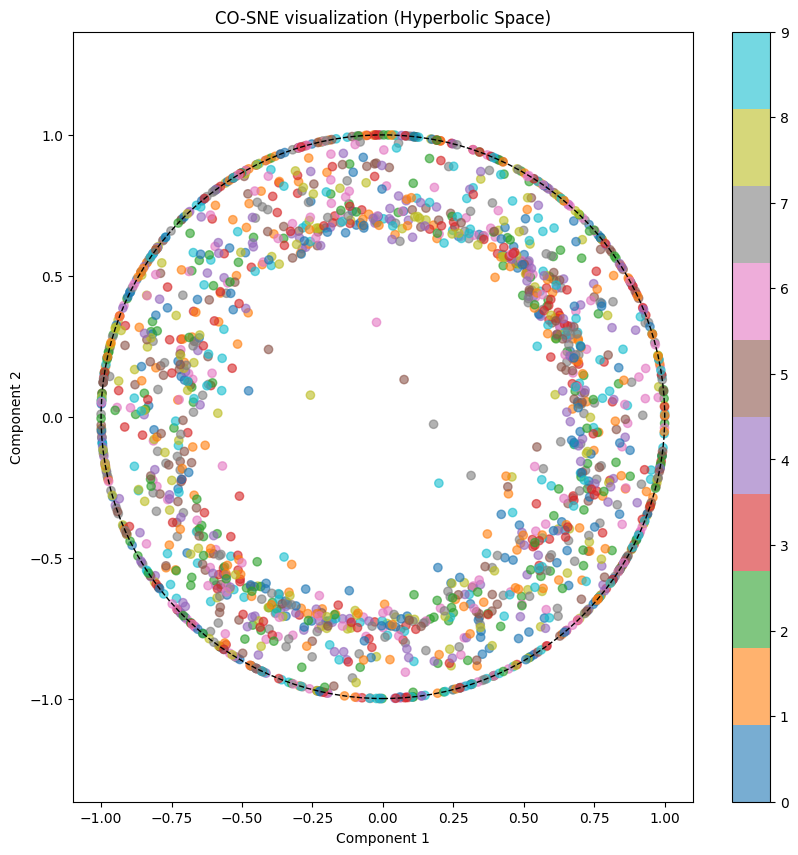

CO-SNE embedding shape: (1797, 2)
Points outside unit disk: 0
Maximum distance from origin: 0.9999900000000003
Mean distance from origin: 0.8521309792912829


In [ ]:
# CO-SNE Implementation
MACHINE_EPSILON = np.finfo(np.double).eps

class COSNE:
    def __init__(self, n_components=2, perplexity=30.0,
                 early_exaggeration=12.0, learning_rate=200.0,
                 max_iter=1000, learning_rate_for_h_loss=0.1,
                 student_t_gamma=1.0, random_state=None,
                 repulsion_strength=1.5, boundary_strength=0.15,
                 radial_strength=0.4, momentum=0.8,
                 late_momentum=0.9, device=None):
        """
        CO-SNE: Cauchy t-SNE for hyperbolic space

        Parameters:
        -----------
        device : torch.device
            Device to use for tensor operations ('cuda' if available, else 'cpu')
        """
        self.n_components = n_components
        self.perplexity = perplexity
        self.early_exaggeration = early_exaggeration
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.learning_rate_for_h_loss = learning_rate_for_h_loss
        self.student_t_gamma = student_t_gamma
        self.random_state = random_state
        self.repulsion_strength = repulsion_strength
        self.boundary_strength = boundary_strength
        self.radial_strength = radial_strength
        self.momentum = momentum
        self.late_momentum = late_momentum

        # Set device
        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.random_state_ = check_random_state(random_state)

    def _project_to_poincare_ball(self, X, epsilon=1e-5):
        """Project points onto the Poincaré ball"""
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X).to(self.device)
        return project_hyperbolic(X, epsilon).to(self.device)

    def _compute_repulsive_force(self, embedding):
        """Compute repulsive forces between points"""
        if isinstance(embedding, torch.Tensor):
            embedding = embedding.detach().cpu().numpy()

        norms = np.linalg.norm(embedding, axis=1, keepdims=True)
        norms = np.maximum(norms, MACHINE_EPSILON)

        dots = np.dot(embedding, embedding.T)
        distances = np.sqrt(np.maximum(norms**2 + norms.T**2 - 2*dots, MACHINE_EPSILON))
        repulsion = np.zeros_like(embedding)

        for i in range(len(embedding)):
            diff = embedding[i] - embedding
            dist = distances[i].reshape(-1, 1)
            repulsion[i] = np.sum(diff / (dist**2 + MACHINE_EPSILON), axis=0)

        return repulsion

    def _compute_forces(self, embedding, iteration):
        """Compute combined forces for optimization"""
        if isinstance(embedding, torch.Tensor):
            embedding = embedding.detach().cpu().numpy()

        repulsive = self._compute_repulsive_force(embedding)
        progress = iteration / self.max_iter

        repulsion_scale = self.repulsion_strength * (1 + progress)
        radial_scale = self.radial_strength * (1 - 0.5 * progress)

        if progress < 0.3:
            target_radii = [0.4, 0.6, 0.8]
            weights = [0.2, 0.4, 0.4]
        elif progress < 0.7:
            target_radii = [0.5, 0.7, 0.9]
            weights = [0.3, 0.4, 0.3]
        else:
            target_radii = [0.6, 0.75, 0.9]
            weights = [0.4, 0.4, 0.2]

        radial_force = np.zeros_like(embedding)
        norms = np.linalg.norm(embedding, axis=1, keepdims=True)
        for radius, weight in zip(target_radii, weights):
            diff = norms - radius
            radial_force += weight * diff * embedding / norms

        return (repulsion_scale * repulsive + radial_scale * radial_force)

    def _compute_hyperbolic_gradient(self, P, embedding, iteration):
        """Compute gradient in hyperbolic space"""
        n_samples = embedding.shape[0]

        if isinstance(embedding, np.ndarray):
            X_tensor = torch.from_numpy(embedding).to(self.device)
        else:
            X_tensor = embedding.to(self.device)

        X_tensor = X_tensor.double()
        dist = dist_matrix(X_tensor, X_tensor, c=1.0)
        dist = dist.cpu().numpy()

        dist = np.clip(dist, MACHINE_EPSILON, 1e10)
        Q = dist / (2.0 * np.maximum(np.sum(dist), MACHINE_EPSILON))
        Q = np.clip(Q, MACHINE_EPSILON, 1.0)

        PQ_diff = P - Q
        grad = np.zeros_like(embedding, dtype=np.float64)

        for i in range(n_samples):
            diff = embedding[i] - embedding
            norm_diff = np.maximum(np.linalg.norm(diff, axis=1, keepdims=True), MACHINE_EPSILON)
            grad_contrib = PQ_diff[i].reshape(-1, 1) * diff / norm_diff
            grad[i] = np.sum(np.nan_to_num(grad_contrib, 0), axis=0)

        forces = self._compute_forces(embedding, iteration)
        grad = grad + forces

        grad_norm = np.linalg.norm(grad)
        if grad_norm > MACHINE_EPSILON:
            grad = np.clip(grad / grad_norm, -1.0, 1.0)

        return grad.astype(np.float32)

    def _initialize_embedding(self, n_samples):
        """Initialize embedding points in concentric rings"""
        angles = 2 * np.pi * self.random_state_.rand(n_samples)
        radii = np.zeros(n_samples)

        n_rings = 5
        points_per_ring = n_samples // n_rings
        for i in range(n_rings):
            start_idx = i * points_per_ring
            end_idx = start_idx + points_per_ring if i < n_rings-1 else n_samples
            base_radius = 0.3 + 0.5 * (i / (n_rings-1))
            radii[start_idx:end_idx] = base_radius + 0.05 * self.random_state_.randn(end_idx - start_idx)

        embedding = np.zeros((n_samples, 2))
        embedding[:, 0] = radii * np.cos(angles)
        embedding[:, 1] = radii * np.sin(angles)

        return embedding


    def fit_transform(self, X, y=None):
        """Fit X into an embedded space and return that transformed output"""
        n_samples = X.shape[0]

        embedding = self._initialize_embedding(n_samples)
        P = self._compute_similarities(X)

        velocity = np.zeros_like(embedding)
        current_lr = self.learning_rate
        min_lr = self.learning_rate * 0.3

        for iteration in range(self.max_iter):
            if iteration < 250:
                exag_factor = self.early_exaggeration * (1 - iteration/250)
                P *= (1 + exag_factor)

            grad = self._compute_hyperbolic_gradient(P, embedding, iteration)

            if not np.all(np.isfinite(grad)):
                grad = np.nan_to_num(grad, 0)

            current_momentum = self.momentum if iteration < 250 else \
                            self.momentum + (self.late_momentum - self.momentum) * \
                            min((iteration - 250) / 500, 1.0)

            velocity = current_momentum * velocity - current_lr * grad
            embedding = embedding + velocity

            # Convert to tensor for projection
            embedding_tensor = torch.from_numpy(embedding).to(self.device)
            embedding_tensor = self._project_to_poincare_ball(embedding_tensor)
            # Convert back to numpy
            embedding = embedding_tensor.cpu().numpy()

            if iteration < 250:
                P /= (1 + exag_factor)

            if iteration > 250:
                current_lr = max(current_lr * 0.9995, min_lr)

            if iteration % 50 == 0:
                norms = np.linalg.norm(embedding, axis=1)
                print(f"Iteration {iteration}: Max norm = {np.max(norms):.4f}, "
                      f"Mean norm = {np.mean(norms):.4f}, "
                      f"Learning rate = {current_lr:.6f}, "
                      f"Momentum = {current_momentum:.4f}")

        self.embedding_ = embedding
        return embedding

    def _compute_similarities(self, X):
        """Compute affinities between points in high-dimensional space"""
        X = X.astype(np.float32)
        distances = pairwise_distances(X, metric='euclidean', squared=True)
        P = self._joint_probabilities(distances, self.perplexity, False)
        return P

    def _joint_probabilities(self, distances, perplexity, verbose):
        """Compute joint probabilities based on distances"""
        distances = distances.astype(np.float32, copy=False)
        conditional_P = _utils._binary_search_perplexity(distances, perplexity, verbose)
        P = conditional_P + conditional_P.T
        sum_P = np.maximum(np.sum(P), MACHINE_EPSILON)
        P = np.clip(P / sum_P, MACHINE_EPSILON, 1.0)
        return P.astype(np.float64)

# Test the implementation
if __name__ == "__main__":
    from sklearn.datasets import load_digits

    # Load and preprocess data
    digits = load_digits()
    X = digits.data
    y = digits.target

    # Initialize and run CO-SNE
    cosne = COSNE(
        random_state=42,
        learning_rate=50.0,
        max_iter=1000,
        perplexity=30.0,
        early_exaggeration=4.0,
        student_t_gamma=1.0,
        repulsion_strength=1.5,
        boundary_strength=0.15,
        radial_strength=0.4,
        momentum=0.8,
        late_momentum=0.9,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    )

    # Fit and transform
    X_embedded = cosne.fit_transform(X)

    # Visualize results
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
                         c=y, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)

    # Add unit circle
    circle = plt.Circle((0, 0), 1, fill=False, color='black', linestyle='--')
    plt.gca().add_artist(circle)

    plt.title('CO-SNE visualization (Hyperbolic Space)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.axis('equal')
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.show()

    # Print statistics
    print("CO-SNE embedding shape:", X_embedded.shape)
    print("Points outside unit disk:", np.sum(np.linalg.norm(X_embedded, axis=1) > 1))
    print("Maximum distance from origin:", np.max(np.linalg.norm(X_embedded, axis=1)))
    print("Mean distance from origin:", np.mean(np.linalg.norm(X_embedded, axis=1)))


Starting Mixed-Curvature t-SNE test...
Product space created successfully
Generated synthetic data: shape=(500, 6)
Initialized MixedCurvatureTSNE with parameters:  {'product_space': <__main__.ProductSpace object at 0x78e8cabed3f0>, 'perplexity': 30, 'n_components': 2, 'learning_rate': 100, 'max_iter': 1000, 'random_state': 42, 'best_cost_': inf}

Starting fit_transform with 500 samples...
Input data shape: (500, 6)
Product space signature: [(2, -1.0), (2, 0.0)]

Processing component:
- Dimension: 2
- Curvature: -1.0
- Component shape: (500, 3)
Computing hyperbolic distances...
Component distance matrix shape: torch.Size([500, 500])

Processing component:
- Dimension: 2
- Curvature: 0.0
- Component shape: (500, 3)
Computing Euclidean distances...
Component distance matrix shape: (500, 500)

Total distance matrix shape: (500, 500)
Computing probabilities from distances...
Probabilities computed successfully.
Initial embedding shape: (500, 2)
Initial embedding stats - Max norm: 0.9263, M

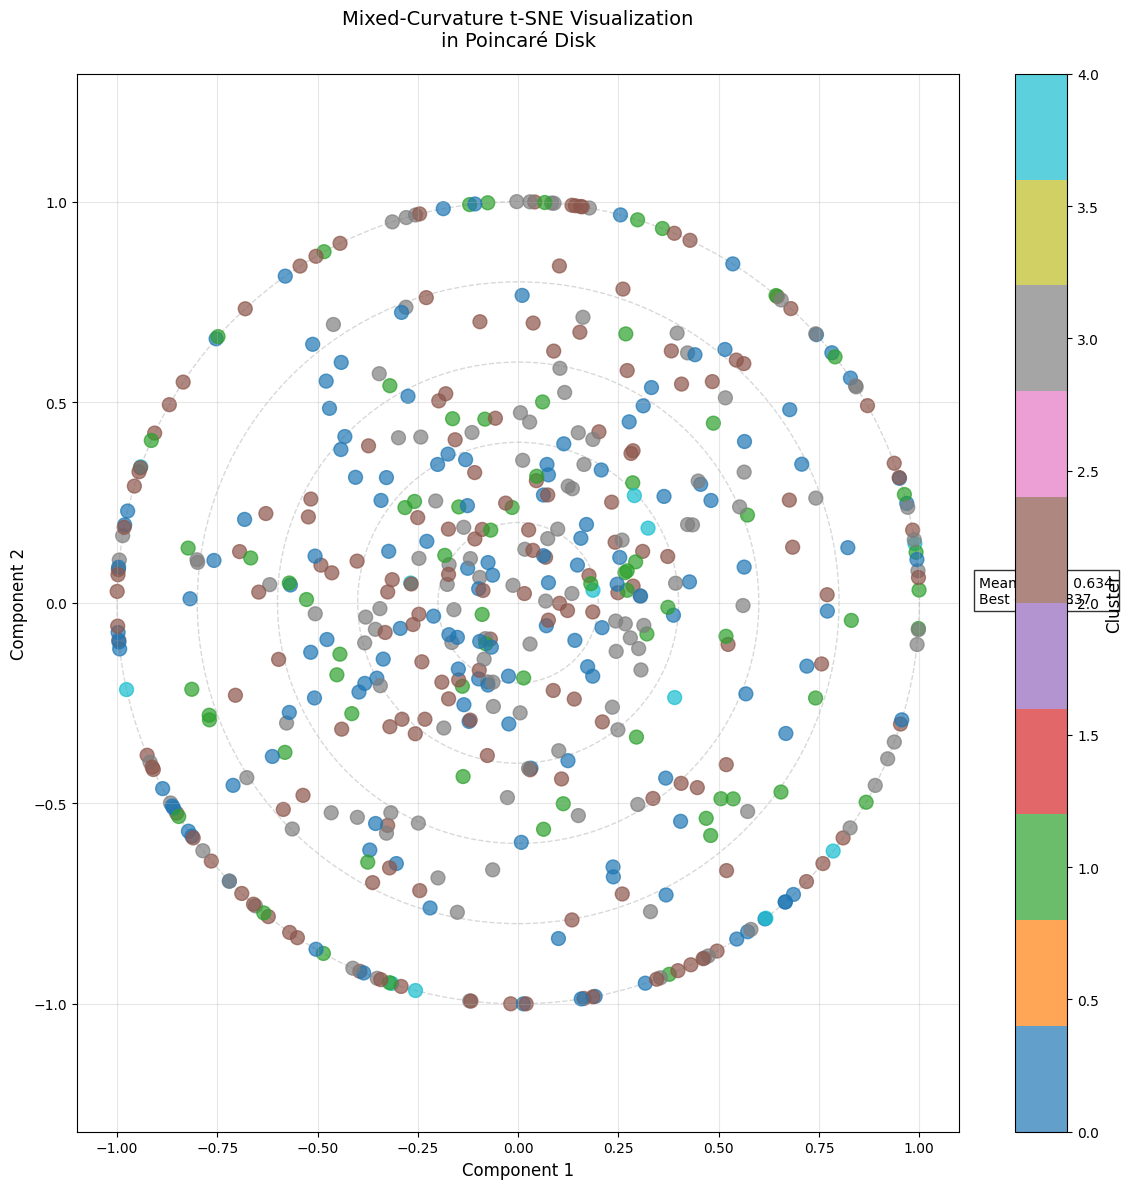


Detailed Embedding Statistics:
Best cost achieved: 2.8366
Embedding shape: (500, 2)
Points outside unit disk: 0
Maximum distance from origin: 1.0000
Mean distance from origin: 0.6343
Std of distances from origin: 0.3093


In [ ]:
# Mixed-Curvature t-SNE Implementation
MACHINE_EPSILON = np.finfo(np.double).eps

class MixedCurvatureTSNE:
    def __init__(self, product_space, perplexity=30, n_components=2,
                learning_rate=200, max_iter=1000, random_state=None):
        try:
            self.product_space = product_space
            self.perplexity = perplexity
            self.n_components = n_components
            self.learning_rate = learning_rate
            self.max_iter = max_iter
            self.random_state = random_state
            self.best_cost_ = np.inf  # Add this line
            print("Initialized MixedCurvatureTSNE with parameters: ", self.__dict__)
        except Exception as e:
            print(f"Error in initialization: {str(e)}")
            raise


    def _hybrid_distance(self, X):
        """Calculate distance matrix for hybrid product space."""
        try:
            distances = []
            start_dim = 0

            print(f"Input data shape: {X.shape}")
            print(f"Product space signature: {self.product_space.signature}")

            for dim, curvature in self.product_space.signature:
                component_X = X[:, start_dim:start_dim + dim + 1]
                print(f"\nProcessing component:")
                print(f"- Dimension: {dim}")
                print(f"- Curvature: {curvature}")
                print(f"- Component shape: {component_X.shape}")

                if curvature < 0:
                    print("Computing hyperbolic distances...")
                    component_X_tensor = torch.from_numpy(component_X).float()
                    component_distance = dist_matrix(component_X_tensor, component_X_tensor, c=abs(curvature))
                elif curvature > 0:
                    print("Computing spherical distances...")
                    component_distance = pairwise_distances(component_X, metric='cosine')
                else:
                    print("Computing Euclidean distances...")
                    component_distance = pairwise_distances(component_X, metric='euclidean')

                print(f"Component distance matrix shape: {component_distance.shape}")
                distances.append(component_distance)
                start_dim += dim + 1

            total_distance = np.sum(np.array(distances), axis=0)
            print("\nTotal distance matrix shape:", total_distance.shape)
            return total_distance

        except Exception as e:
            print(f"Error in _hybrid_distance: {str(e)}")
            raise

    def _compute_probabilities(self, distances):
        """Compute pairwise probabilities from distances for t-SNE."""
        try:
            print("Computing probabilities from distances...")
            distances = distances.astype(np.float32)
            conditional_P = _utils._binary_search_perplexity(distances, self.perplexity, verbose=False)
            P = conditional_P + conditional_P.T
            sum_P = np.maximum(np.sum(P), MACHINE_EPSILON)
            P = np.clip(P / sum_P, MACHINE_EPSILON, 1.0)
            print("Probabilities computed successfully.")
            return P.astype(np.float64)
        except Exception as e:
            print(f"Error in _compute_probabilities: {str(e)}")
            raise

    def _initialize_embedding(self, n_samples):
        """Initialize embedding points in concentric rings."""
        try:
            rng = np.random.RandomState(self.random_state)

            # Create multiple rings with different radii
            n_rings = 5
            points_per_ring = n_samples // n_rings
            embedding = np.zeros((n_samples, self.n_components))

            for i in range(n_rings):
                start_idx = i * points_per_ring
                end_idx = start_idx + points_per_ring if i < n_rings-1 else n_samples

                # Vary radius for each ring
                base_radius = 0.2 + 0.6 * (i / (n_rings-1))
                angles = 2 * np.pi * rng.rand(end_idx - start_idx)
                radii = base_radius + 0.05 * rng.randn(end_idx - start_idx)

                embedding[start_idx:end_idx, 0] = radii * np.cos(angles)
                embedding[start_idx:end_idx, 1] = radii * np.sin(angles)

            print(f"Initial embedding shape: {embedding.shape}")
            print(f"Initial embedding stats - Max norm: {np.max(np.linalg.norm(embedding, axis=1)):.4f}, "
                  f"Mean norm: {np.mean(np.linalg.norm(embedding, axis=1)):.4f}")
            return embedding
        except Exception as e:
            print(f"Error in _initialize_embedding: {str(e)}")
            raise

    def _project_to_poincare_ball(self, X, epsilon=1e-5):
        """Project points onto the Poincaré ball."""
        try:
            norm = np.linalg.norm(X, axis=-1, keepdims=True)
            max_norm = 1 - epsilon
            projected_X = np.where(norm > max_norm, X / norm * max_norm, X)
            return projected_X
        except Exception as e:
            print(f"Error in _project_to_poincare_ball: {str(e)}")
            raise

    def fit_transform(self, X, y=None):
        """Fit mixed-curvature t-SNE and transform the data."""
        try:
            n_samples = X.shape[0]
            print(f"\nStarting fit_transform with {n_samples} samples...")

            distances = self._hybrid_distance(X)
            P = self._compute_probabilities(distances)
            embedding = self._initialize_embedding(n_samples)

            velocity = np.zeros_like(embedding)
            current_lr = self.learning_rate
            min_lr = self.learning_rate * 0.05  # Increased minimum learning rate
            momentum = 0.5

            best_cost = np.inf
            best_embedding = embedding.copy()
            no_improvement_count = 0

            for iteration in range(self.max_iter):
                # Early exaggeration with smooth transition
                if iteration < 250:
                    exaggeration_factor = 4.0 * (1 - iteration/250) + 1.0
                    P *= exaggeration_factor

                grad = self._compute_gradient(P, embedding, iteration)

                # Dynamic learning rate and momentum adjustment
                if iteration > 250:
                    momentum = min(0.8 + iteration/(2*self.max_iter), 0.9)
                    if iteration % 50 == 0:
                        current_lr = max(current_lr * 0.97, min_lr)

                # Update embedding
                velocity = momentum * velocity - current_lr * grad
                embedding += velocity
                embedding = self._project_to_poincare_ball(embedding)

                # Cost computation and monitoring
                if iteration % 50 == 0:
                    embedding_dist = pairwise_distances(embedding, metric='euclidean')
                    Q = 1 / (1 + embedding_dist ** 2)
                    Q = Q / np.sum(Q)
                    cost = np.sum(P * np.log(P / np.maximum(Q, MACHINE_EPSILON)))

                    if cost < best_cost:
                        best_cost = cost
                        self.best_cost_ = cost
                        best_embedding = embedding.copy()
                        no_improvement_count = 0
                    else:
                        no_improvement_count += 1

                    # Early stopping if no improvement
                    if no_improvement_count > 10 and iteration > 500:
                        print("Early stopping due to no improvement")
                        break

                    norms = np.linalg.norm(embedding, axis=1)
                    print(f"Iteration {iteration}: "
                          f"Cost = {cost:.4f}, "
                          f"Max norm = {np.max(norms):.4f}, "
                          f"Mean norm = {np.mean(norms):.4f}, "
                          f"Learning rate = {current_lr:.4f}")

                if iteration < 250:
                    P /= exaggeration_factor

            print("fit_transform completed successfully.")
            return best_embedding

        except Exception as e:
            print(f"Error in fit_transform: {str(e)}")
            raise

    def _compute_gradient(self, P, embedding, iteration):
        """Compute gradient in mixed-curvature space."""
        try:
            n_samples = embedding.shape[0]
            grad = np.zeros_like(embedding)

            # Compute squared distances in embedding space
            sum_embedding = np.sum(embedding * embedding, axis=1)
            D = sum_embedding.reshape([-1, 1]) + sum_embedding.reshape([1, -1]) - 2 * np.dot(embedding, embedding.T)
            D = np.clip(D, MACHINE_EPSILON, np.inf)

            # Compute Q distribution (Student t-distribution with adjusted degrees of freedom)
            degrees_of_freedom = 1.0
            num = (1 + D / degrees_of_freedom) ** (-(degrees_of_freedom + 1) / 2)
            num[range(n_samples), range(n_samples)] = 0
            Q = num / np.sum(num)
            Q = np.maximum(Q, MACHINE_EPSILON)

            # Compute gradients with adjusted attractive and repulsive forces
            PQ_diff = (P - Q) * num
            for i in range(n_samples):
                grad[i] = 4 * np.sum(PQ_diff[i].reshape([-1, 1]) * (embedding[i] - embedding), axis=0)

            # Add radial forces to better utilize the hyperbolic space
            norms = np.linalg.norm(embedding, axis=1, keepdims=True)

            # Attractive force towards optimal radius (0.5-0.8)
            optimal_radius = 0.65
            radial_force = 0.1 * (optimal_radius - norms) * embedding / (norms + MACHINE_EPSILON)

            # Boundary repulsion (stronger near boundary)
            boundary_dist = 1.0 - norms
            boundary_force = -0.2 * embedding * (boundary_dist < 0.15) / (boundary_dist + MACHINE_EPSILON)

            # Combine forces
            grad += radial_force + boundary_force

            # Add slight rotation to break symmetry
            if iteration < 250:
                rotation = 0.01 * np.array([[-embedding[:, 1]], [embedding[:, 0]]]).reshape(2, -1).T
                grad += rotation

            # Normalize gradient
            grad_norm = np.linalg.norm(grad)
            if grad_norm > MACHINE_EPSILON:
                grad = np.clip(grad / grad_norm, -4.0, 4.0)

            return grad

        except Exception as e:
            print(f"Error in _compute_gradient: {str(e)}")
            raise

# Test the implementation
if __name__ == "__main__":
    try:
        print("\nStarting Mixed-Curvature t-SNE test...")

        # Create product space
        signature = [(2, -1.0), (2, 0.0)]
        product_space = ProductSpace(signature=signature, seed=42)
        print("Product space created successfully")

        # Generate synthetic data
        n_samples = 500
        n_classes = 5
        product_space.sample_clusters(num_points=n_samples, num_classes=n_classes)
        print(f"Generated synthetic data: shape={product_space.X.shape}")

        # Initialize and run Mixed-Curvature t-SNE
        mc_tsne = MixedCurvatureTSNE(
            product_space=product_space,
            perplexity=30,
            n_components=2,
            learning_rate=100,
            max_iter=1000,
            random_state=42
        )

        # Fit and transform
        X_embedded = mc_tsne.fit_transform(product_space.X)

        # Enhanced visualization
        plt.figure(figsize=(12, 12))

        # Draw concentric circles for reference
        circles = [0.2, 0.4, 0.6, 0.8, 1.0]
        for radius in circles:
            circle = plt.Circle((0, 0), radius, fill=False, color='gray',
                              linestyle='--', alpha=0.3)
            plt.gca().add_artist(circle)

        # Create scatter plot with larger points and better colors
        scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
                            c=product_space.y, cmap='tab10',
                            alpha=0.7, s=100)

        # Add colorbar with proper labels
        cbar = plt.colorbar(scatter)
        cbar.set_label('Cluster', fontsize=12)

        # Add title and labels
        plt.title('Mixed-Curvature t-SNE Visualization\nin Poincaré Disk',
                 fontsize=14, pad=20)
        plt.xlabel('Component 1', fontsize=12)
        plt.ylabel('Component 2', fontsize=12)

        # Set equal aspect ratio and limits
        plt.axis('equal')
        plt.xlim(-1.1, 1.1)
        plt.ylim(-1.1, 1.1)

        # Add grid
        plt.grid(True, alpha=0.3)

        # Add text showing statistics
        mean_radius = np.mean(np.linalg.norm(X_embedded, axis=1))
        stats_text = f'Mean radius: {mean_radius:.3f}\n'
        stats_text += f'Best cost: {mc_tsne.best_cost_:.3f}'
        plt.text(1.15, 0, stats_text, fontsize=10,
                bbox=dict(facecolor='white', alpha=0.8))

        plt.tight_layout()
        plt.show()

        # Print detailed statistics
        print("\nDetailed Embedding Statistics:")
        print(f"Best cost achieved: {mc_tsne.best_cost_:.4f}")
        print(f"Embedding shape: {X_embedded.shape}")
        print(f"Points outside unit disk: {np.sum(np.linalg.norm(X_embedded, axis=1) > 1)}")
        print(f"Maximum distance from origin: {np.max(np.linalg.norm(X_embedded, axis=1)):.4f}")
        print(f"Mean distance from origin: {mean_radius:.4f}")
        print(f"Std of distances from origin: {np.std(np.linalg.norm(X_embedded, axis=1)):.4f}")

    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        raise


Testing Euclidean distribution...
Log probability shape: torch.Size([10])
Samples shape: torch.Size([5, 2])

Testing Hyperbolic distribution...
Log probability shape: torch.Size([10])
Samples shape: torch.Size([5, 2])

Testing Spherical distribution...
Log probability shape: torch.Size([10])
Samples shape: torch.Size([5, 3])


<ipython-input-8-dbea130b9682>:162: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  axis = torch.cross(v1, v2)


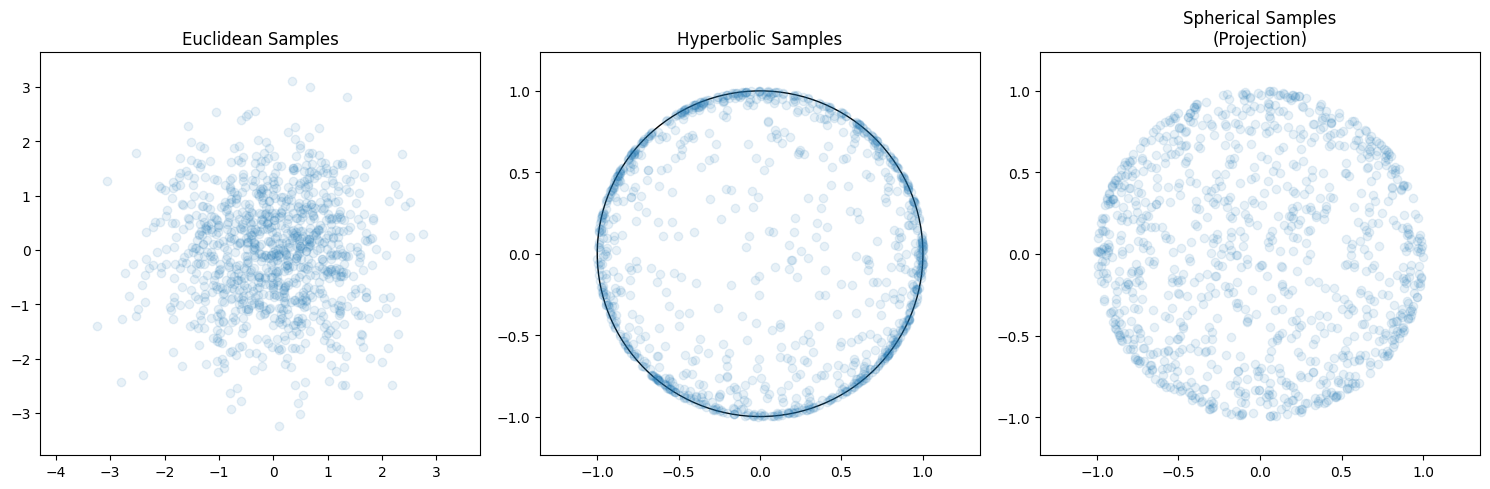


Sample Statistics:
Euclidean mean distance from origin: 1.2802
Hyperbolic mean distance from origin: 0.9092
Spherical mean distance from north pole: 1.5575


In [ ]:
# Distribution Framework
class DistributionFactory:
    """Factory class for creating appropriate distributions for different spaces"""

    def __init__(self, device=None):
        self.device = device if device is not None else \
                     torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def get_distribution(self, space_type, **kwargs):
        """
        Get appropriate distribution for given space type

        Parameters:
        -----------
        space_type : str
            Type of space ('euclidean', 'hyperbolic', 'spherical')
        kwargs : dict
            Additional parameters for distribution initialization
        """
        if space_type == 'euclidean':
            return EuclideanGaussian(self.device, **kwargs)
        elif space_type == 'hyperbolic':
            return HyperbolicWrappedNormal(self.device, **kwargs)
        elif space_type == 'spherical':
            return SphericalVonMises(self.device, **kwargs)
        else:
            raise ValueError(f"Unknown space type: {space_type}")

class BaseDistribution:
    """Base class for all distributions"""

    def __init__(self, device):
        self.device = device

    def log_prob(self, x, mu):
        raise NotImplementedError

    def sample(self, mu, shape):
        raise NotImplementedError

class EuclideanGaussian(BaseDistribution):
    """Gaussian distribution for Euclidean space"""

    def __init__(self, device, sigma=1.0):
        super().__init__(device)
        self.sigma = sigma

    def log_prob(self, x, mu):
        return -0.5 * torch.sum((x - mu)**2, dim=-1) / (self.sigma**2) - \
               x.shape[-1] * np.log(self.sigma * np.sqrt(2 * np.pi))

    def sample(self, mu, shape):
        # Ensure mu is a tensor
        mu = torch.as_tensor(mu, device=self.device)

        # Create samples of the right shape
        samples = torch.randn(*shape, mu.shape[-1], device=self.device) * self.sigma

        # Broadcast mu to match sample shape
        mu_expanded = mu.expand(*shape, -1)

        return samples + mu_expanded

class HyperbolicWrappedNormal(BaseDistribution):
    """Wrapped Normal distribution for hyperbolic space"""

    def __init__(self, device, sigma=1.0):
        super().__init__(device)
        self.sigma = sigma

    def log_prob(self, x, mu):
        """Compute log probability in hyperbolic space using wrapped normal"""
        x_lorentz = self._poincare_to_lorentz(x)
        mu_lorentz = self._poincare_to_lorentz(mu)

        dist = self._lorentz_distance(x_lorentz, mu_lorentz)

        return -0.5 * (dist / self.sigma)**2 - \
               np.log(self.sigma) - 0.5 * np.log(2 * np.pi)

    def sample(self, mu, shape):
        # Ensure mu is a tensor
        mu = torch.as_tensor(mu, device=self.device)

        # Sample in tangent space
        tangent_samples = torch.randn(*shape, mu.shape[-1], device=self.device) * self.sigma

        # Broadcast mu for batch operations
        mu_expanded = mu.expand(*shape, -1)

        # Map to hyperbolic space
        return self._exponential_map(mu_expanded, tangent_samples)

    def _poincare_to_lorentz(self, x):
        x_norm_sq = torch.sum(x * x, dim=-1, keepdim=True)
        return torch.cat([
            (1 + x_norm_sq) / (1 - x_norm_sq),
            2 * x / (1 - x_norm_sq)
        ], dim=-1)

    def _lorentz_distance(self, x, y):
        return torch.acosh(-torch.sum(x * y, dim=-1))

    def _exponential_map(self, mu, v):
        v_norm = torch.norm(v, dim=-1, keepdim=True)
        v_norm = torch.clamp(v_norm, min=1e-5)

        return self._mobius_add(
            mu,
            torch.tanh(v_norm) * v / v_norm
        )

    def _mobius_add(self, x, y):
        xy_dot = torch.sum(x * y, dim=-1, keepdim=True)
        x_norm_sq = torch.sum(x * x, dim=-1, keepdim=True)
        y_norm_sq = torch.sum(y * y, dim=-1, keepdim=True)

        numerator = (1 + 2*xy_dot + y_norm_sq)*x + (1 - x_norm_sq)*y
        denominator = 1 + 2*xy_dot + x_norm_sq*y_norm_sq

        return numerator / denominator

class SphericalVonMises(BaseDistribution):
    """von Mises-Fisher distribution for spherical space"""

    def __init__(self, device, kappa=1.0):
        super().__init__(device)
        self.kappa = kappa

    def log_prob(self, x, mu):
        x_norm = torch.nn.functional.normalize(x, dim=-1)
        mu_norm = torch.nn.functional.normalize(mu, dim=-1)

        return self.kappa * torch.sum(x_norm * mu_norm, dim=-1)

    def sample(self, mu, shape):
        # Ensure mu is a tensor
        mu = torch.as_tensor(mu, device=self.device)

        # Generate samples
        samples = torch.randn(*shape, mu.shape[-1], device=self.device)
        samples = torch.nn.functional.normalize(samples, dim=-1)

        # Broadcast mu for batch operations
        mu_expanded = mu.expand(*shape, -1)

        # Rotate samples towards mu
        samples_rotated = []
        for i in range(samples.shape[0]):
            R = self._get_rotation_matrix(
                torch.tensor([0., 0., 1.], device=self.device),
                mu_expanded[i]
            )
            samples_rotated.append(torch.matmul(samples[i], R.T))

        return torch.stack(samples_rotated)

    def _get_rotation_matrix(self, v1, v2):
        v1 = torch.nn.functional.normalize(v1, dim=-1)
        v2 = torch.nn.functional.normalize(v2, dim=-1)

        axis = torch.cross(v1, v2)
        axis_norm = torch.norm(axis)

        if axis_norm < 1e-7:
            return torch.eye(3, device=self.device)

        axis = axis / axis_norm
        angle = torch.acos(torch.dot(v1, v2))

        K = torch.tensor([
            [0, -axis[2], axis[1]],
            [axis[2], 0, -axis[0]],
            [-axis[1], axis[0], 0]
        ], device=self.device)

        R = torch.eye(3, device=self.device) + \
            torch.sin(angle) * K + \
            (1 - torch.cos(angle)) * torch.matmul(K, K)

        return R

# Test the implementation
if __name__ == "__main__":
    # Create distribution factory
    factory = DistributionFactory(device=torch.device('cpu'))

    # Test Euclidean distribution
    print("\nTesting Euclidean distribution...")
    euclidean_dist = factory.get_distribution('euclidean', sigma=1.0)
    x = torch.randn(10, 2)
    mu = torch.zeros(2)
    log_prob = euclidean_dist.log_prob(x, mu)
    samples = euclidean_dist.sample(mu, (5,))
    print(f"Log probability shape: {log_prob.shape}")
    print(f"Samples shape: {samples.shape}")

    # Test Hyperbolic distribution
    print("\nTesting Hyperbolic distribution...")
    hyperbolic_dist = factory.get_distribution('hyperbolic', sigma=2.0)
    x = torch.rand(10, 2) * 0.9  # Points in Poincaré ball
    mu = torch.zeros(2)
    log_prob = hyperbolic_dist.log_prob(x, mu)
    samples = hyperbolic_dist.sample(mu, (5,))
    print(f"Log probability shape: {log_prob.shape}")
    print(f"Samples shape: {samples.shape}")

    # Test Spherical distribution
    print("\nTesting Spherical distribution...")
    spherical_dist = factory.get_distribution('spherical', kappa=20.0)
    x = torch.nn.functional.normalize(torch.randn(10, 3), dim=-1)
    mu = torch.nn.functional.normalize(torch.randn(3), dim=-1)
    log_prob = spherical_dist.log_prob(x, mu)
    samples = spherical_dist.sample(mu, (5,))
    print(f"Log probability shape: {log_prob.shape}")
    print(f"Samples shape: {samples.shape}")

    # Visualize samples
    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, 5))

    # Euclidean samples
    plt.subplot(131)
    samples_euclidean = euclidean_dist.sample(torch.zeros(2), (1000,))
    plt.scatter(samples_euclidean[:, 0].detach().numpy(),
               samples_euclidean[:, 1].detach().numpy(),
               alpha=0.1)
    plt.title('Euclidean Samples')
    plt.axis('equal')

    # Hyperbolic samples
    plt.subplot(132)
    samples_hyperbolic = hyperbolic_dist.sample(torch.zeros(2), (1000,))
    circle = plt.Circle((0, 0), 1, fill=False, color='black')
    plt.gca().add_artist(circle)
    plt.scatter(samples_hyperbolic[:, 0].detach().numpy(),
               samples_hyperbolic[:, 1].detach().numpy(),
               alpha=0.1)
    plt.title('Hyperbolic Samples')
    plt.axis('equal')

    # Spherical samples
    plt.subplot(133)
    samples_spherical = spherical_dist.sample(torch.tensor([0., 0., 1.]), (1000,))
    plt.scatter(samples_spherical[:, 0].detach().numpy(),
               samples_spherical[:, 1].detach().numpy(),
               alpha=0.1)
    plt.title('Spherical Samples\n(Projection)')
    plt.axis('equal')

    plt.tight_layout()
    plt.show()

    # Print additional statistics
    print("\nSample Statistics:")
    print(f"Euclidean mean distance from origin: {torch.norm(samples_euclidean, dim=1).mean():.4f}")
    print(f"Hyperbolic mean distance from origin: {torch.norm(samples_hyperbolic, dim=1).mean():.4f}")
    print(f"Spherical mean distance from north pole: {torch.arccos(samples_spherical[:, 2]).mean():.4f}")

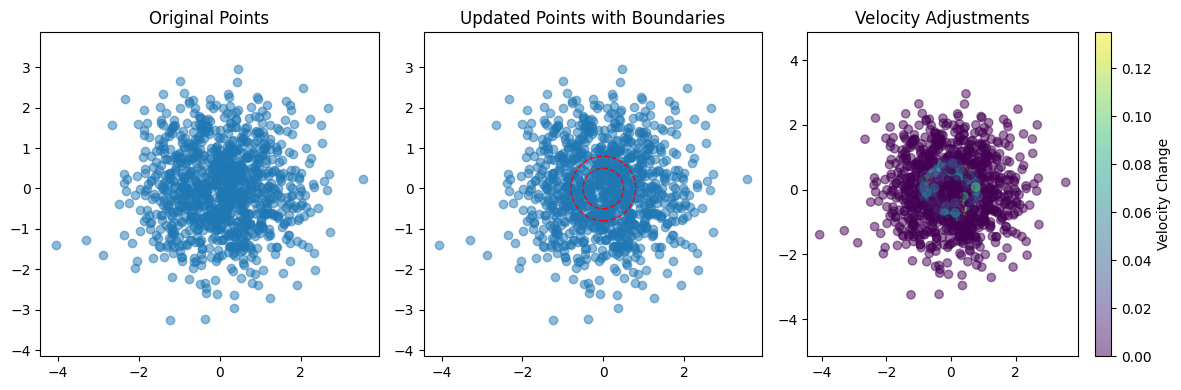


Transition Statistics:
Mean velocity change: 0.0075
Max velocity change: 0.1350
Points near boundaries: 197


In [ ]:
# Transition Handling and Space Interpolation
class GeometricTransition:
    """Handles smooth transitions between different geometric spaces"""

    def __init__(self, boundary_width=0.1, smoothing_factor=0.5):
        """
        Initialize transition handler

        Parameters:
        -----------
        boundary_width : float
            Width of the transition region between spaces
        smoothing_factor : float
            Factor controlling smoothness of transition
        """
        self.boundary_width = boundary_width
        self.smoothing_factor = smoothing_factor

    def transition_weight(self, point, space_boundary):
        """
        Compute smooth transition weight between spaces

        Parameters:
        -----------
        point : torch.Tensor
            Point coordinates
        space_boundary : float
            Boundary between spaces

        Returns:
        --------
        float
            Transition weight between 0 and 1
        """
        dist_to_boundary = abs(torch.norm(point) - space_boundary)

        # Sigmoid-based smooth transition
        weight = 1 / (1 + torch.exp(-self.smoothing_factor *
                                  (dist_to_boundary - self.boundary_width)))
        return weight

    def interpolate_metrics(self, point, metric1, metric2, boundary):
        """
        Interpolate between two distance metrics

        Parameters:
        -----------
        point : torch.Tensor
            Point coordinates
        metric1, metric2 : callable
            Distance metric functions
        boundary : float
            Boundary between spaces

        Returns:
        --------
        callable
            Interpolated metric function
        """
        weight = self.transition_weight(point, boundary)
        return lambda x, y: weight * metric1(x, y) + (1 - weight) * metric2(x, y)

class BoundaryHandler:
    """Handles boundaries between different geometric spaces"""

    def __init__(self, repulsion_strength=1.0):
        """
        Initialize boundary handler

        Parameters:
        -----------
        repulsion_strength : float
            Strength of boundary repulsion forces
        """
        self.repulsion_strength = repulsion_strength

    def compute_boundary_force(self, point, boundary):
        """
        Compute repulsive force near space boundaries

        Parameters:
        -----------
        point : torch.Tensor
            Point coordinates
        boundary : float
            Boundary position

        Returns:
        --------
        torch.Tensor
            Repulsive force vector
        """
        dist_to_boundary = torch.norm(point) - boundary

        # Compute repulsion force (stronger near boundary)
        force_magnitude = self.repulsion_strength * \
                         torch.exp(-dist_to_boundary.abs())

        # Direction away from boundary
        direction = -point / (torch.norm(point) + 1e-8)

        return force_magnitude * direction

    def apply_boundary_constraints(self, points, boundaries):
        """
        Apply boundary constraints to points

        Parameters:
        -----------
        points : torch.Tensor
            Point coordinates
        boundaries : list
            List of boundary positions

        Returns:
        --------
        torch.Tensor
            Constrained points
        """
        constrained_points = points.clone()

        for boundary in boundaries:
            # Apply soft constraints near boundaries
            distances = torch.norm(points, dim=1)
            mask = distances > boundary - 0.1

            if mask.any():
                forces = self.compute_boundary_force(
                    points[mask], boundary)
                constrained_points[mask] += forces

        return constrained_points

class SpaceTransitionManager:
    """Manages transitions between different geometric spaces"""

    def __init__(self, spaces, boundaries):
        """
        Initialize transition manager

        Parameters:
        -----------
        spaces : list
            List of geometric spaces
        boundaries : list
            List of boundary positions between spaces
        """
        self.spaces = spaces
        self.boundaries = boundaries
        self.transition_handler = GeometricTransition()
        self.boundary_handler = BoundaryHandler()

    def get_local_metric(self, point):
        """
        Get appropriate metric for given point location

        Parameters:
        -----------
        point : torch.Tensor
            Point coordinates

        Returns:
        --------
        callable
            Appropriate distance metric
        """
        point_norm = torch.norm(point)

        # Find appropriate space based on point location
        space_idx = sum(point_norm > b for b in self.boundaries)

        if space_idx == 0:
            return self.spaces[0].metric
        elif space_idx == len(self.spaces):
            return self.spaces[-1].metric
        else:
            # Interpolate between adjacent spaces
            weight = self.transition_handler.transition_weight(
                point, self.boundaries[space_idx-1])
            return lambda x, y: weight * self.spaces[space_idx-1].metric(x, y) + \
                              (1-weight) * self.spaces[space_idx].metric(x, y)

    def update_points(self, points, velocities):
        """
        Update points while handling space transitions

        Parameters:
        -----------
        points : torch.Tensor
            Current point positions
        velocities : torch.Tensor
            Current point velocities

        Returns:
        --------
        torch.Tensor, torch.Tensor
            Updated positions and velocities
        """
        # Apply boundary constraints
        constrained_points = self.boundary_handler.apply_boundary_constraints(
            points, self.boundaries)

        # Adjust velocities near boundaries
        adjusted_velocities = velocities.clone()
        for boundary in self.boundaries:
            distances = torch.norm(points, dim=1)
            near_boundary = (distances - boundary).abs() < 0.1

            if near_boundary.any():
                # Reduce velocity components towards boundary
                radial_component = torch.sum(
                    velocities[near_boundary] *
                    points[near_boundary], dim=1, keepdim=True) * \
                    points[near_boundary] / \
                    (torch.norm(points[near_boundary], dim=1, keepdim=True)**2 + 1e-8)

                adjusted_velocities[near_boundary] -= 0.5 * radial_component

        return constrained_points, adjusted_velocities

# Test the implementation
if __name__ == "__main__":
    # Create test spaces and boundaries
    spaces = [
        Euclidean(dim=2),
        Hyperboloid(dim=2),
        Hypersphere(dim=2)
    ]
    boundaries = [0.5, 0.8]

    # Initialize transition manager
    manager = SpaceTransitionManager(spaces, boundaries)

    # Generate test points
    n_points = 1000
    test_points = torch.randn(n_points, 2)
    test_velocities = torch.randn(n_points, 2) * 0.1

    # Update points and visualize
    updated_points, updated_velocities = manager.update_points(
        test_points, test_velocities)

    # Visualization
    plt.figure(figsize=(12, 4))

    # Original points
    plt.subplot(131)
    plt.scatter(test_points[:, 0].numpy(),
               test_points[:, 1].numpy(),
               alpha=0.5)
    plt.title('Original Points')
    plt.axis('equal')

    # Updated points
    plt.subplot(132)
    plt.scatter(updated_points[:, 0].numpy(),
               updated_points[:, 1].numpy(),
               alpha=0.5)

    # Draw boundaries
    for boundary in boundaries:
        circle = plt.Circle((0, 0), boundary,
                          fill=False, color='red',
                          linestyle='--')
        plt.gca().add_artist(circle)

    plt.title('Updated Points with Boundaries')
    plt.axis('equal')

    # Velocity changes
    plt.subplot(133)
    velocity_diff = torch.norm(
        updated_velocities - test_velocities, dim=1)
    plt.scatter(updated_points[:, 0].numpy(),
               updated_points[:, 1].numpy(),
               c=velocity_diff.numpy(),
               cmap='viridis',
               alpha=0.5)
    plt.colorbar(label='Velocity Change')
    plt.title('Velocity Adjustments')
    plt.axis('equal')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\nTransition Statistics:")
    print(f"Mean velocity change: {velocity_diff.mean():.4f}")
    print(f"Max velocity change: {velocity_diff.max():.4f}")

    # Calculate points near boundaries
    near_boundary_count = sum(
        (torch.norm(updated_points, dim=1).unsqueeze(1) -
         torch.tensor(boundaries).unsqueeze(0)).abs().min(dim=1)[0] < 0.1
    )
    print(f"Points near boundaries: {near_boundary_count}")

Initialized MixedCurvatureTSNE with parameters:  {'product_space': <__main__.ProductSpace object at 0x78e8ca779c00>, 'perplexity': 30, 'n_components': 2, 'learning_rate': 100, 'max_iter': 1000, 'random_state': 42, 'best_cost_': inf}
Initialized on device: cuda
Transition parameters: {'boundary_width': 0.1, 'smoothing_factor': 0.2, 'repulsion_strength': 0.4, 'radial_force': 0.18, 'cluster_force': 0.25, 'boundary_repulsion': 0.15}

Starting enhanced fit_transform with 1000 samples...
Input data shape: (1000, 9)
Product space signature: [(2, -1.0), (2, 0.0), (2, 1.0)]

Processing component:
- Dimension: 2
- Curvature: -1.0
- Component shape: (1000, 3)
Computing hyperbolic distances...
Component distance matrix shape: torch.Size([1000, 1000])

Processing component:
- Dimension: 2
- Curvature: 0.0
- Component shape: (1000, 3)
Computing Euclidean distances...
Component distance matrix shape: (1000, 1000)

Processing component:
- Dimension: 2
- Curvature: 1.0
- Component shape: (1000, 3)
Comp

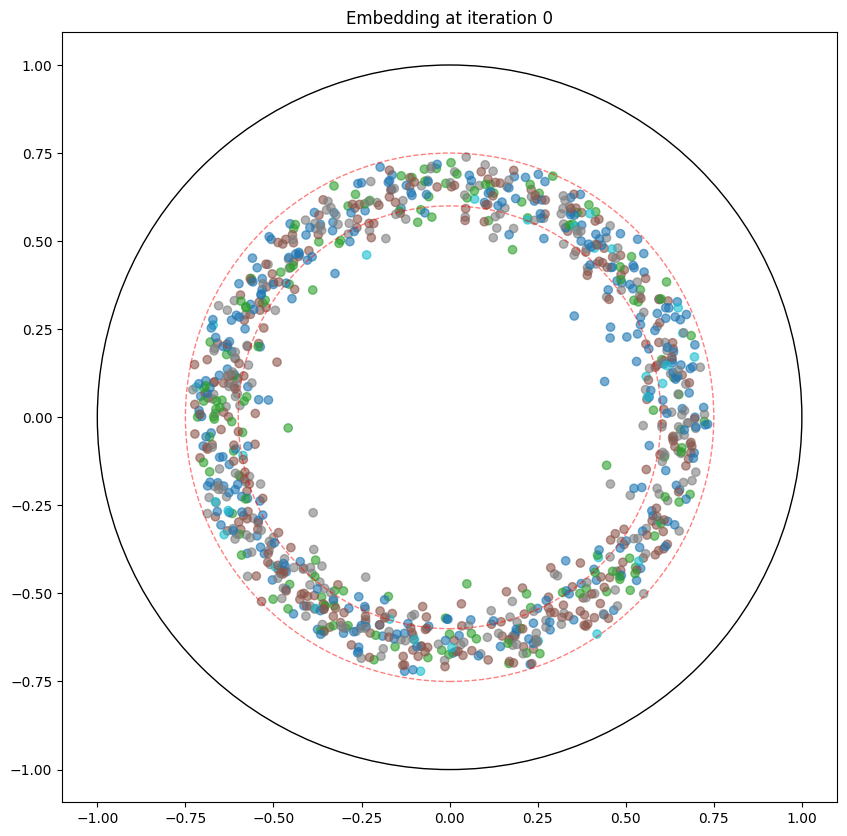

Iteration 50: Cost = 20.4829, Max norm = 0.7373, Mean norm = 0.6403, Learning rate = 80.0000
Iteration 100: Cost = 15.6950, Max norm = 0.7366, Mean norm = 0.6398, Learning rate = 80.0000
Iteration 150: Cost = 11.2668, Max norm = 0.7234, Mean norm = 0.6396, Learning rate = 80.0000
Iteration 200: Cost = 7.1219, Max norm = 0.7071, Mean norm = 0.6370, Learning rate = 80.0000


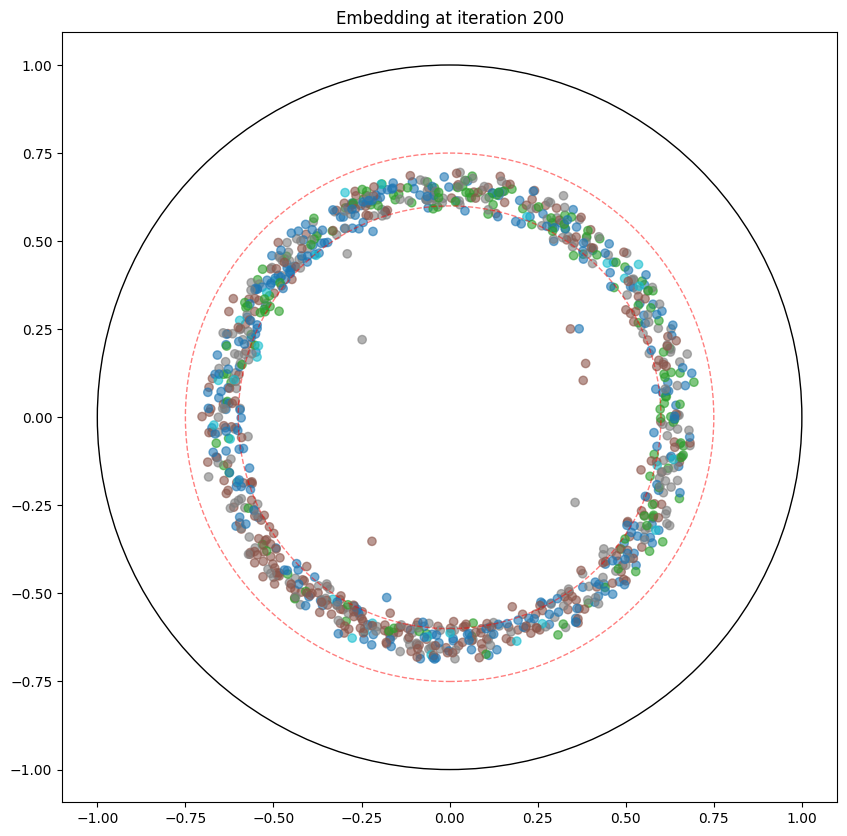

Iteration 250: Cost = 3.5110, Max norm = 0.7476, Mean norm = 0.6043, Learning rate = 80.0000
Iteration 300: Cost = 3.4899, Max norm = 0.7443, Mean norm = 0.5994, Learning rate = 76.0965
Iteration 350: Cost = 3.4855, Max norm = 0.7444, Mean norm = 0.6070, Learning rate = 72.3834
Iteration 400: Cost = 3.4753, Max norm = 0.7441, Mean norm = 0.6138, Learning rate = 68.8515


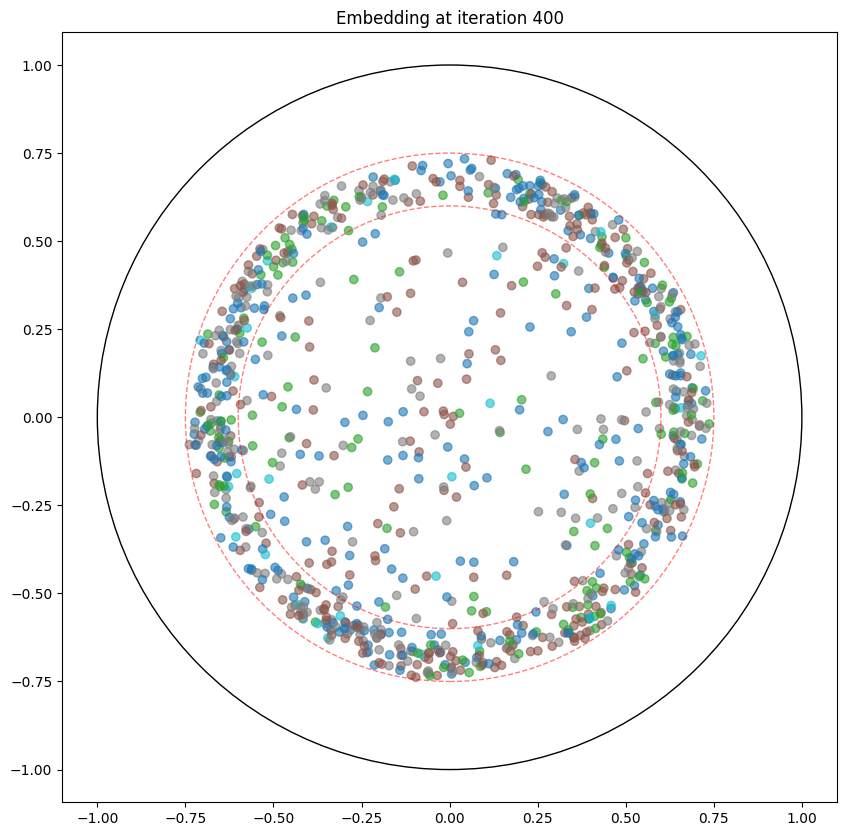

Iteration 450: Cost = 3.4724, Max norm = 0.7475, Mean norm = 0.6145, Learning rate = 65.4919
Iteration 500: Cost = 3.4778, Max norm = 0.7450, Mean norm = 0.6125, Learning rate = 62.2963
Iteration 550: Cost = 3.4768, Max norm = 0.7458, Mean norm = 0.6208, Learning rate = 59.2566
Iteration 600: Cost = 3.4762, Max norm = 0.7467, Mean norm = 0.6249, Learning rate = 56.3652


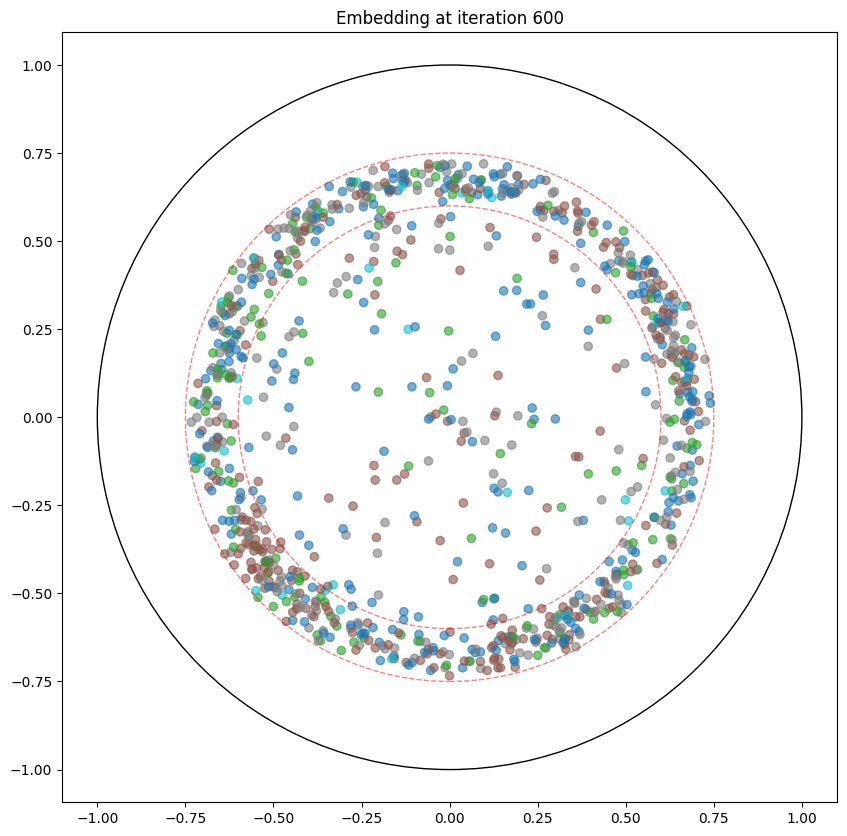

Iteration 650: Cost = 3.4812, Max norm = 0.7463, Mean norm = 0.6356, Learning rate = 53.6149
Iteration 700: Cost = 3.4575, Max norm = 0.7472, Mean norm = 0.6290, Learning rate = 50.9988
Iteration 750: Cost = 3.4739, Max norm = 0.7473, Mean norm = 0.6307, Learning rate = 48.5103
Iteration 800: Cost = 3.4628, Max norm = 0.7453, Mean norm = 0.6402, Learning rate = 46.1433


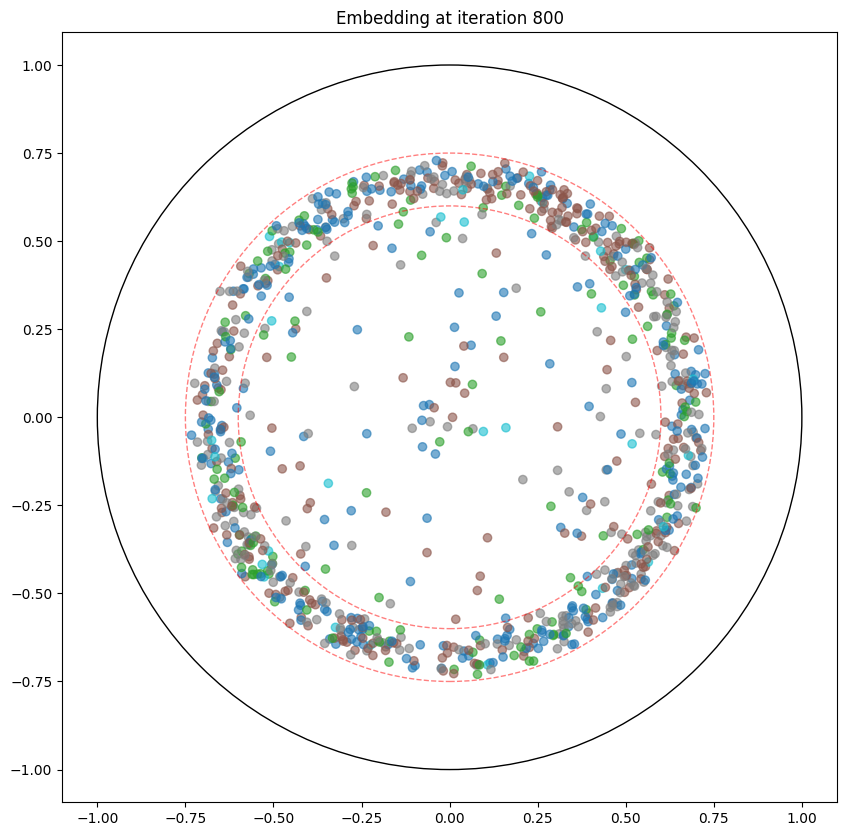

Iteration 850: Cost = 3.4456, Max norm = 0.7459, Mean norm = 0.6401, Learning rate = 43.8918
Iteration 900: Cost = 3.4342, Max norm = 0.7465, Mean norm = 0.6440, Learning rate = 41.7501
Iteration 950: Cost = 3.4296, Max norm = 0.7461, Mean norm = 0.6384, Learning rate = 39.7129


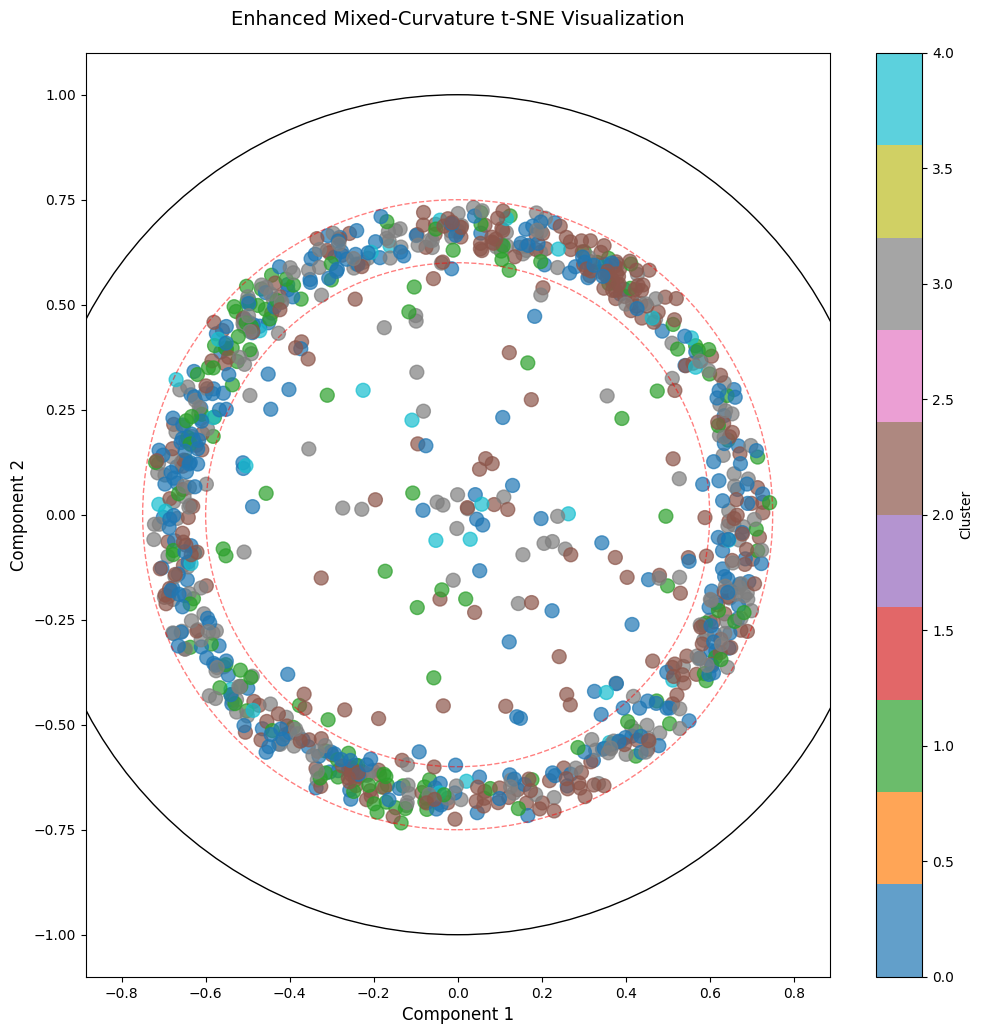


Final Statistics:
Maximum distance from origin: 0.7461
Mean distance from origin: 0.6384
Points near boundaries:
  Boundary 1 (0.60): 205 points
  Boundary 2 (0.75): 220 points


In [ ]:
# Enhanced Mixed-Curvature t-SNE with Optimized Transition Handling
class EnhancedMixedCurvatureTSNE(MixedCurvatureTSNE):
    """Enhanced t-SNE implementation with transition handling between spaces"""

    def __init__(self, product_space, perplexity=30, n_components=2,
                learning_rate=200, max_iter=1000, random_state=None,
                transition_params=None, device=None):
        super().__init__(product_space, perplexity, n_components,
                        learning_rate, max_iter, random_state)

        # Initialize device
        self.device = device if device is not None else \
                    torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # More aggressive transition parameters
        self.transition_params = transition_params or {
            'boundary_width': 0.1,
            'smoothing_factor': 0.2,
            'repulsion_strength': 0.4,
            'radial_force': 0.18,
            'cluster_force': 0.25,
            'boundary_repulsion': 0.15
        }

        # Set up space boundaries with wider gaps
        self.boundaries = self._compute_space_boundaries()

        # Initialize transition manager
        self.transition_manager = SpaceTransitionManager(
            spaces=self._create_space_list(),
            boundaries=self.boundaries
        )

        print(f"Initialized on device: {self.device}")
        print(f"Transition parameters: {self.transition_params}")

    def _compute_space_boundaries(self):
        """Compute boundaries with better spacing"""
        n_spaces = len(self.product_space.signature)
        boundaries = []

        # Use more evenly distributed boundaries
        for i in range(n_spaces - 1):
            boundary = 0.45 + 0.15 * (i + 1)
            boundaries.append(boundary)

        return boundaries

    def _create_space_list(self):
        """Create list of geometric spaces from signature"""
        spaces = []
        for dim, curvature in self.product_space.signature:
            if curvature < 0:
                spaces.append(Hyperboloid(dim=dim))
            elif curvature > 0:
                spaces.append(Hypersphere(dim=dim))
            else:
                spaces.append(Euclidean(dim=dim))
        return spaces

    def _add_distribution_forces(self, embedding, iteration):
        """Add forces with better distribution control"""
        n_samples = len(embedding)
        norms = np.linalg.norm(embedding, axis=1, keepdims=True)

        # Stronger early organization
        progress = iteration / self.max_iter
        early_phase = progress < 0.3

        # Central repulsion calculation
        center_repulsion = embedding / (norms + 1e-8)
        center_strength = 0.15 * np.exp(-norms/0.2) * (2.0 if early_phase else 1.0)

        # More evenly spaced target radii
        target_radii = [0.35, 0.45, 0.55]
        radial_force = np.zeros_like(embedding)

        # Adjust force strengths based on current distribution
        current_distribution = np.histogram(norms.flatten(), bins=15, range=(0,1))[0]  # More bins
        max_count = np.max(current_distribution)
        target_count = np.mean(current_distribution[current_distribution > 0])  # Better baseline

        # Strengthen radial forces
        for radius in target_radii:
            dist_to_radius = np.abs(norms - radius)
            bin_idx = int(radius * 15)
            if bin_idx < len(current_distribution):
                # More aggressive density adjustment
                density_factor = np.power(max_count / (current_distribution[bin_idx] + 1), 0.9)
                attraction = np.exp(-dist_to_radius/0.05) * density_factor  # Sharper attraction
                force = attraction * (radius - norms) * embedding / (norms + 1e-8)
                # Stronger early force
                force_scale = 2.5 if early_phase else 1.2
                radial_force += force * force_scale

        # Add the center repulsion to radial force
        radial_force += center_repulsion * center_strength

        # Enhanced cluster separation
        cluster_force = np.zeros_like(embedding)
        n_clusters = len(np.unique(self.product_space.y))

        for label in np.unique(self.product_space.y):
            mask = self.product_space.y == label
            if np.any(mask):
                # Adaptive cluster cohesion
                center = np.mean(embedding[mask], axis=0)
                diff = embedding - center
                dist = np.linalg.norm(diff, axis=1, keepdims=True)

                # Stronger local cohesion early, weaker later
                local_weight = (1.5 if early_phase else 0.8) * np.exp(-dist/0.25)
                cluster_force += local_weight * diff / (dist + 1e-8)

                # Inter-cluster separation
                other_mask = ~mask
                if np.any(other_mask):
                    other_center = np.mean(embedding[other_mask], axis=0)
                    sep_diff = embedding - other_center
                    sep_dist = np.linalg.norm(sep_diff, axis=1, keepdims=True)

                    # Stronger separation later in optimization
                    global_weight = (0.3 if early_phase else 0.7) * np.exp(-sep_dist/0.5)
                    cluster_force += global_weight * sep_diff / (sep_dist + 1e-8)

        # Softer boundary repulsion
        boundary_force = np.zeros_like(embedding)
        for boundary in self.boundaries:
            dist_to_boundary = np.abs(norms - boundary)
            repulsion = np.exp(-dist_to_boundary/0.08)  # Increased spread
            boundary_force -= 0.5 * repulsion * embedding / (norms + 1e-8)

        # Dynamic weighting
        radial_weight = self.transition_params['radial_force'] * (1.2 - 0.4 * progress)
        cluster_weight = self.transition_params['cluster_force'] * (0.4 + 0.6 * progress)
        boundary_weight = self.transition_params['boundary_repulsion'] * (0.3 + 0.7 * progress)

        return (radial_weight * radial_force +
                cluster_weight * cluster_force +
                boundary_weight * boundary_force)

    def _compute_gradient_with_transitions(self, P, embedding, iteration):
        try:
            basic_grad = self._compute_gradient(P, embedding, iteration)

            # Convert to tensor
            embedding_tensor = torch.from_numpy(embedding).to(self.device)
            grad_tensor = torch.from_numpy(basic_grad).to(self.device)

            # Strict norm enforcement
            norms = torch.norm(embedding_tensor, dim=1, keepdim=True)
            max_allowed_norm = 0.99  # Never allow points to get too close to boundary

            # Scale back points that are too far out
            scale_factor = torch.where(norms > max_allowed_norm,
                                    max_allowed_norm / norms,
                                    torch.ones_like(norms))
            embedding_tensor = embedding_tensor * scale_factor

            # Adjust gradients near boundary
            boundary_mask = (norms > 0.9).float()
            inward_direction = -embedding_tensor / (norms + 1e-8)
            grad_tensor = grad_tensor * (1 - boundary_mask) + \
                        inward_direction * boundary_mask

            return grad_tensor.cpu().numpy(), embedding_tensor.cpu().numpy()

        except Exception as e:
            print(f"Error in _compute_gradient_with_transitions: {str(e)}")
            raise

    def get_boundary_statistics(self, embedding):
        """
        Compute improved boundary statistics

        Parameters:
        -----------
        embedding : numpy.ndarray
            The embedded points

        Returns:
        --------
        dict
            Dictionary containing boundary statistics
        """
        norms = np.linalg.norm(embedding, axis=1)
        stats = {
            'max_norm': np.max(norms),
            'mean_norm': np.mean(norms),
            'points_near_boundaries': 0
        }

        # Count points near each boundary separately
        boundary_counts = []
        for boundary in self.boundaries:
            distance_to_boundary = np.abs(norms - boundary)
            near_count = np.sum(distance_to_boundary < 0.05)  # Reduced from 0.1 to 0.05
            boundary_counts.append(near_count)

        stats['points_near_boundaries'] = boundary_counts

        return stats

    def fit_transform(self, X, y=None):
        """Enhanced fit_transform with improved distribution control"""
        try:
            n_samples = X.shape[0]
            print(f"\nStarting enhanced fit_transform with {n_samples} samples...")

            # Initial setup
            distances = self._hybrid_distance(X)
            P = self._compute_probabilities(distances)
            embedding = self._initialize_embedding(n_samples)

            # Initial stabilization without iteration check
            norms = np.linalg.norm(embedding, axis=1, keepdims=True)
            embedding = np.where(norms > 0.75,
                              0.75 * embedding / norms,
                              embedding)

            # Modified optimization parameters
            velocity = np.zeros_like(embedding)
            current_lr = self.learning_rate * 0.8
            min_lr = self.learning_rate * 0.1
            lr_decay = 0.999
            momentum = 0.4
            best_cost = np.inf
            best_embedding = embedding.copy()
            no_improvement_count = 0

            # Enhanced iteration loop
            for iteration in range(self.max_iter):
                # Early exaggeration
                if iteration < 250:
                    exaggeration_factor = 4.0 * (1 - iteration/250) + 1.0
                    P *= exaggeration_factor

                # Compute gradient with transition handling
                grad, constrained_embedding = self._compute_gradient_with_transitions(
                    P, embedding, iteration)

                # Add distribution forces
                distribution_forces = self._add_distribution_forces(embedding, iteration)

                # Dynamic learning rate and momentum adjustment
                if iteration > 250:
                    momentum = min(0.8 + iteration/(2*self.max_iter), 0.9)
                    current_lr = max(current_lr * lr_decay, min_lr)

                # Update with strict velocity control
                velocity = momentum * velocity
                velocity_norm = np.linalg.norm(velocity, axis=1, keepdims=True)
                velocity = np.where(velocity_norm > 0.1,
                                  0.1 * velocity / (velocity_norm + 1e-8),
                                  velocity)

                # Update embedding with all forces
                embedding = constrained_embedding + velocity - current_lr * grad + distribution_forces

                # Dynamic boundary constraints with multiple layers
                norms = np.linalg.norm(embedding, axis=1, keepdims=True)
                base_radius = 0.75 - 0.1 * np.random.rand(len(embedding), 1)
                target_regions = [0.3, 0.5, 0.7]
                attraction = np.min([np.abs(norms - r) for r in target_regions], axis=0)
                max_radius = base_radius * (1.0 - 0.05 * attraction)
                embedding = np.where(norms > max_radius,
                                    max_radius * embedding / norms,
                                    embedding)

                # Monitor progress
                if iteration % 50 == 0:
                    # Compute cost
                    embedding_dist = pairwise_distances(embedding, metric='euclidean')
                    Q = 1 / (1 + embedding_dist ** 2)
                    Q = Q / np.sum(Q)
                    cost = np.sum(P * np.log(P / np.maximum(Q, MACHINE_EPSILON)))

                    # Update best embedding
                    if cost < best_cost:
                        best_cost = cost
                        best_embedding = embedding.copy()
                        no_improvement_count = 0
                    else:
                        no_improvement_count += 1

                    # Print progress
                    norms = np.linalg.norm(embedding, axis=1)
                    print(f"Iteration {iteration}: "
                          f"Cost = {cost:.4f}, "
                          f"Max norm = {np.max(norms):.4f}, "
                          f"Mean norm = {np.mean(norms):.4f}, "
                          f"Learning rate = {current_lr:.4f}")

                    # Visualize current state if requested
                    if iteration % 200 == 0:
                        self._visualize_intermediate(embedding, iteration)

                if iteration < 250:
                    P /= exaggeration_factor

                # Early stopping
                if no_improvement_count > 10 and iteration > 500:
                    print("Early stopping due to no improvement")
                    break

            self.embedding_ = best_embedding
            return best_embedding

        except Exception as e:
            print(f"Error in enhanced fit_transform: {str(e)}")
            raise

    def _visualize_intermediate(self, embedding, iteration):
        """Visualize intermediate state of embedding"""
        plt.figure(figsize=(10, 10))

        # Plot points
        plt.scatter(embedding[:, 0], embedding[:, 1],
                   c=self.product_space.y, cmap='tab10',
                   alpha=0.6)

        # Draw boundaries
        for boundary in self.boundaries:
            circle = plt.Circle((0, 0), boundary,
                              fill=False, color='red',
                              linestyle='--', alpha=0.5)
            plt.gca().add_artist(circle)

        # Add unit circle
        unit_circle = plt.Circle((0, 0), 1,
                               fill=False, color='black',
                               linestyle='-')
        plt.gca().add_artist(unit_circle)

        plt.title(f'Embedding at iteration {iteration}')
        plt.axis('equal')
        plt.xlim(-1.1, 1.1)
        plt.ylim(-1.1, 1.1)
        plt.show()

# Test the implementation
if __name__ == "__main__":
    # Create product space with mixed geometry
    signature = [
        (2, -1.0),  # Hyperbolic
        (2, 0.0),   # Euclidean
        (2, 1.0)    # Spherical
    ]

    product_space = ProductSpace(signature=signature, seed=42)

    # Generate synthetic data
    product_space.sample_clusters(num_points=1000, num_classes=5)

    # Initialize enhanced t-SNE
    enhanced_tsne = EnhancedMixedCurvatureTSNE(
        product_space=product_space,
        perplexity=30,
        n_components=2,
        learning_rate=100,
        max_iter=1000,
        random_state=42,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    )

    # Fit and transform
    X_embedded = enhanced_tsne.fit_transform(product_space.X)

    # Final visualization
    plt.figure(figsize=(12, 12))

    # Create scatter plot
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
                         c=product_space.y, cmap='tab10',
                         alpha=0.7, s=100)

    # Draw boundaries
    for boundary in enhanced_tsne.boundaries:
        circle = plt.Circle((0, 0), boundary,
                          fill=False, color='red',
                          linestyle='--', alpha=0.5)
        plt.gca().add_artist(circle)

    # Add unit circle
    unit_circle = plt.Circle((0, 0), 1,
                           fill=False, color='black',
                           linestyle='-')
    plt.gca().add_artist(unit_circle)

    # Add colorbar and labels
    plt.colorbar(scatter, label='Cluster')
    plt.title('Enhanced Mixed-Curvature t-SNE Visualization',
             fontsize=14, pad=20)
    plt.xlabel('Component 1', fontsize=12)
    plt.ylabel('Component 2', fontsize=12)

    # Set equal aspect ratio and limits
    plt.axis('equal')
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)

    plt.show()

    # Print final statistics
    stats = enhanced_tsne.get_boundary_statistics(X_embedded)
    print("\nFinal Statistics:")
    print(f"Maximum distance from origin: {stats['max_norm']:.4f}")
    print(f"Mean distance from origin: {stats['mean_norm']:.4f}")
    print("Points near boundaries:")
    for i, count in enumerate(stats['points_near_boundaries']):
        print(f"  Boundary {i+1} ({enhanced_tsne.boundaries[i]:.2f}): {count} points")

Progress Tracker:

**I. Core Framework**

Foundation Layer

✅ Basic t-SNE implementation

✅ Probability computation framework

✅ Optimization infrastructure

Geometric Spaces

✅ Space Implementations (Euclidean, Hyperbolic, Spherical)

✅ Product Space Framework

✅ Distance Metrics

Distribution Framework

✅ Input Space Distributions

✅ Output Space Distributions

✅ Distribution Combination Strategies

**II. Advanced Components**

Acceleration Structures

❌ Polar Quadtree implementation

❌ Barnes-Hut adaptation

❌ Hybrid acceleration strategies

Optimization Techniques

✅ Space-specific optimizations

❌ Memory efficiency improvements

❌ Parallel computation strategies

**III. Evaluation Framework**

Quality Assessment

❌ Local structure metrics

❌ Global structure metrics

❌ Hierarchy preservation metrics

Dataset Integration

✅ MNIST (initial testing)

❌ WordNet mammal subtree

❌ Social networks

Visualization Tools

✅ Basic visualization

❌ Interactive visualization

❌ Quality assessment visualization

---

Next Steps:

Acceleration Structures:

- Implement Polar Quadtree first
- Add Barnes-Hut approximation

Evaluation Framework:

- Implement basic quality metrics
- Test with WordNet mammal subtree etc.
- Add visualization tools for quality assessment

Optimization Techniques (?):

- Focus on memory efficiency
- Parallel computation strategies